Zbiór danych: https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland?resource=download

Dataset zawiera informacje o nieruchomościach na sprzedaż w Polsce z czerwca 2024r  

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor

data_path = 'apartments_pl_2024_06.csv'

apartments_data = pd.read_csv(data_path)
apartments_data.drop(axis=1, inplace=True, columns='id')

num_rows, num_columns = apartments_data.shape

print(f"Liczba rekordów (wierszy): {num_rows}")
print(f"Liczba cech (kolumn): {num_columns}")

pd.set_option('display.max_columns', None)
print(apartments_data.head())

Liczba rekordów (wierszy): 21501
Liczba cech (kolumn): 27
       city               type  squareMeters  rooms  floor  floorCount  \
0  szczecin       blockOfFlats         47.00    2.0    6.0        12.0   
1  szczecin  apartmentBuilding         88.22    3.0    1.0         2.0   
2  szczecin  apartmentBuilding        117.00    5.0    4.0         4.0   
3  szczecin       blockOfFlats         33.31    1.0    1.0         4.0   
4  szczecin       blockOfFlats         56.00    3.0    7.0         7.0   

   buildYear   latitude  longitude  centreDistance  poiCount  schoolDistance  \
0     1981.0  53.428544  14.552812            0.79      67.0           0.288   
1     2000.0  53.449093  14.516844            4.09       0.0           0.509   
2        NaN  53.443096  14.561348            2.19      10.0           0.216   
3     1963.0  53.436100  14.541200            1.93      39.0           0.073   
4     2018.0  53.447465  14.557811            2.68      10.0           0.268   

   clinicDistanc

In [2]:
from random import sample, randint

# deleting random data from the dataset
for col in apartments_data.columns[:-1]:
    present_column_values = apartments_data[col].notnull()
    non_missing_indices = apartments_data[present_column_values].index.tolist()

    if apartments_data[col].isnull().sum() < 0.03 * num_rows:
        num_to_remove = int(len(non_missing_indices) * randint(1, 10) / 100)
        indices_to_remove = sample(non_missing_indices, num_to_remove)
        apartments_data.loc[indices_to_remove, col] = None


Zbiór zawiera 21501 rekordów, liczba cech w całym zbiorze wynosi 28. Do przeprowadzenia regresji zostaną wykorzystane następujące cechy:

1. squareMeters – metraż mieszkania w metrach kwadratowych
2. city – miasto, w którym znajduje się mieszkanie
3. rooms – liczba pokoi w mieszkaniu
4. floor – piętro, na którym znajduje się lokal
5. floorCount – liczba pięter w całym budynku
6. buildYear – rok budowy nieruchomości
7. latitude – szerokość geograficzna mieszkania
8. longitude – długość geograficzna mieszkania
9. centreDistance – odległość od centrum miasta (w km)
10. poiCount – liczba punktów zainteresowania w pobliżu (np. sklepy, usługi)
11. schoolDistance – odległość do najbliższej szkoły (w km)
12. clinicDistance – odległość do najbliższej przychodni (w km)
13. postOfficeDistance – odległość do najbliższej poczty (w km)
14. kindergartenDistance – odległość do najbliższego przedszkola (w km)
15. restaurantDistance – odległość do najbliższej restauracji (w km)
16. collegeDistance – odległość do najbliższej uczelni wyższej (w km)
17. pharmacyDistance – odległość do najbliższej apteki (w km)
18. hasElevator – czy mieszkanie znajduje się w budynku z windą (tak/nie)
19. hasParkingSpace – czy mieszkanie posiada miejsce parkingowe (tak/nie)
20. hasStorageRoom – czy mieszkanie posiada komórkę lokatorską (tak/nie)
21. hasBalcony – czy mieszkanie posiada balkon (tak/nie)
22. hasSecurity – czy budynek posiada monitoring lub ochronę (tak/nie)
23. type – typ nieruchomości (blockOfFlats, apartmentBuilding, tenement)
24. buildingMaterial – materiał, z którego wykonano budynek (brick, concreteSlab)
25. ownership – forma własności (condominium, cooperative, udział)
26. condition – stan techniczny lokalu (low, standard, premium)
27. price – cena mieszkania w złotych

Zbiór posłuży do przeprowadzenia regresji cen mieszkań, z wykorzystaniem powyższych cech.

In [3]:
selected_columns = [
    'city', 'type', 'squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear',
    'latitude', 'longitude', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance',
    'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance', 'collegeDistance',
    'pharmacyDistance', 'ownership', 'buildingMaterial', 'condition', 'hasParkingSpace',
    'hasBalcony', 'hasElevator', 'hasSecurity', 'hasStorageRoom', 'price'
]

missing_values = apartments_data[selected_columns].isnull().sum()

missing_percentage = (missing_values / len(apartments_data) * 100).round(2).astype(str) + "%"

print("Brakujące wartości dla wszystkich cech:")
print(missing_percentage)


Brakujące wartości dla wszystkich cech:
city                      2.0%
type                    20.45%
squareMeters              7.0%
rooms                     4.0%
floor                   16.62%
floorCount               5.92%
buildYear               15.72%
latitude                  3.0%
longitude                 4.0%
centreDistance            5.0%
poiCount                  1.0%
schoolDistance           2.05%
clinicDistance           5.27%
postOfficeDistance       2.09%
kindergartenDistance     9.08%
restaurantDistance       1.14%
collegeDistance          10.5%
pharmacyDistance        10.13%
ownership                 3.0%
buildingMaterial        40.89%
condition               74.05%
hasParkingSpace          10.0%
hasBalcony                5.0%
hasElevator              4.46%
hasSecurity               1.0%
hasStorageRoom            2.0%
price                     0.0%
dtype: object


In [4]:
error_counts = {}

valid_values = {
    "hasElevator": ["yes", "no"],
    "hasParkingSpace": ["yes", "no"],
    "hasStorageRoom": ["yes", "no"],
    "type": ["blockOfFlats", "apartmentBuilding", "tenement"],
    "buildingMaterial": ["brick", "concreteSlab"],
    "hasSecurity": ["yes", "no"],
    "hasBalcony": ["yes", "no"],
    "ownership": ["condominium", "udział", "cooperative"],
    "condition": ["premium", "low"]
}

for col, valid in valid_values.items():
    invalid_values = apartments_data[~apartments_data[col].isin(valid)][col].dropna()
    error_counts[col] = len(invalid_values)

invalid_city = apartments_data['city'].str.strip() == ""

valid_ranges = {
    "squareMeters": (10, 500),
    "rooms": (1, 10),
    "floor": (0, 50),
    "floorCount": (1, 50),
    "buildYear": (1800, 2025),
    "centreDistance": (0, 100),
    "poiCount": (0, 500),
    "schoolDistance": (0, 100),
    "clinicDistance": (0, 100),
    "postOfficeDistance": (0, 100),
    "kindergartenDistance": (0, 100),
    "restaurantDistance": (0, 100),
    "collegeDistance": (0, 100),
    "pharmacyDistance": (0, 100),
    "latitude": (-90, 90),
    "longitude": (-180, 180),
    "price": (50000, 5000000)
}

for col, (min_val, max_val) in valid_ranges.items():
    invalid_values = apartments_data[
        (apartments_data[col] < min_val) | (apartments_data[col] > max_val)
        ][col]
    error_counts[col] = len(invalid_values)

total_rows = len(apartments_data)
for col, count in error_counts.items():
    percent = round((count / total_rows) * 100, 2)
    print(f"{col.ljust(20)} {str(count).ljust(5)} ({percent}%)")

hasElevator          0     (0.0%)
hasParkingSpace      0     (0.0%)
hasStorageRoom       0     (0.0%)
type                 0     (0.0%)
buildingMaterial     0     (0.0%)
hasSecurity          0     (0.0%)
hasBalcony           0     (0.0%)
ownership            0     (0.0%)
condition            0     (0.0%)
squareMeters         0     (0.0%)
rooms                0     (0.0%)
floor                0     (0.0%)
floorCount           0     (0.0%)
buildYear            0     (0.0%)
centreDistance       0     (0.0%)
poiCount             0     (0.0%)
schoolDistance       0     (0.0%)
clinicDistance       0     (0.0%)
postOfficeDistance   0     (0.0%)
kindergartenDistance 0     (0.0%)
restaurantDistance   0     (0.0%)
collegeDistance      0     (0.0%)
pharmacyDistance     0     (0.0%)
latitude             0     (0.0%)
longitude            0     (0.0%)
price                0     (0.0%)


Zbiór nie zawiera niepoprawnych wartości.  

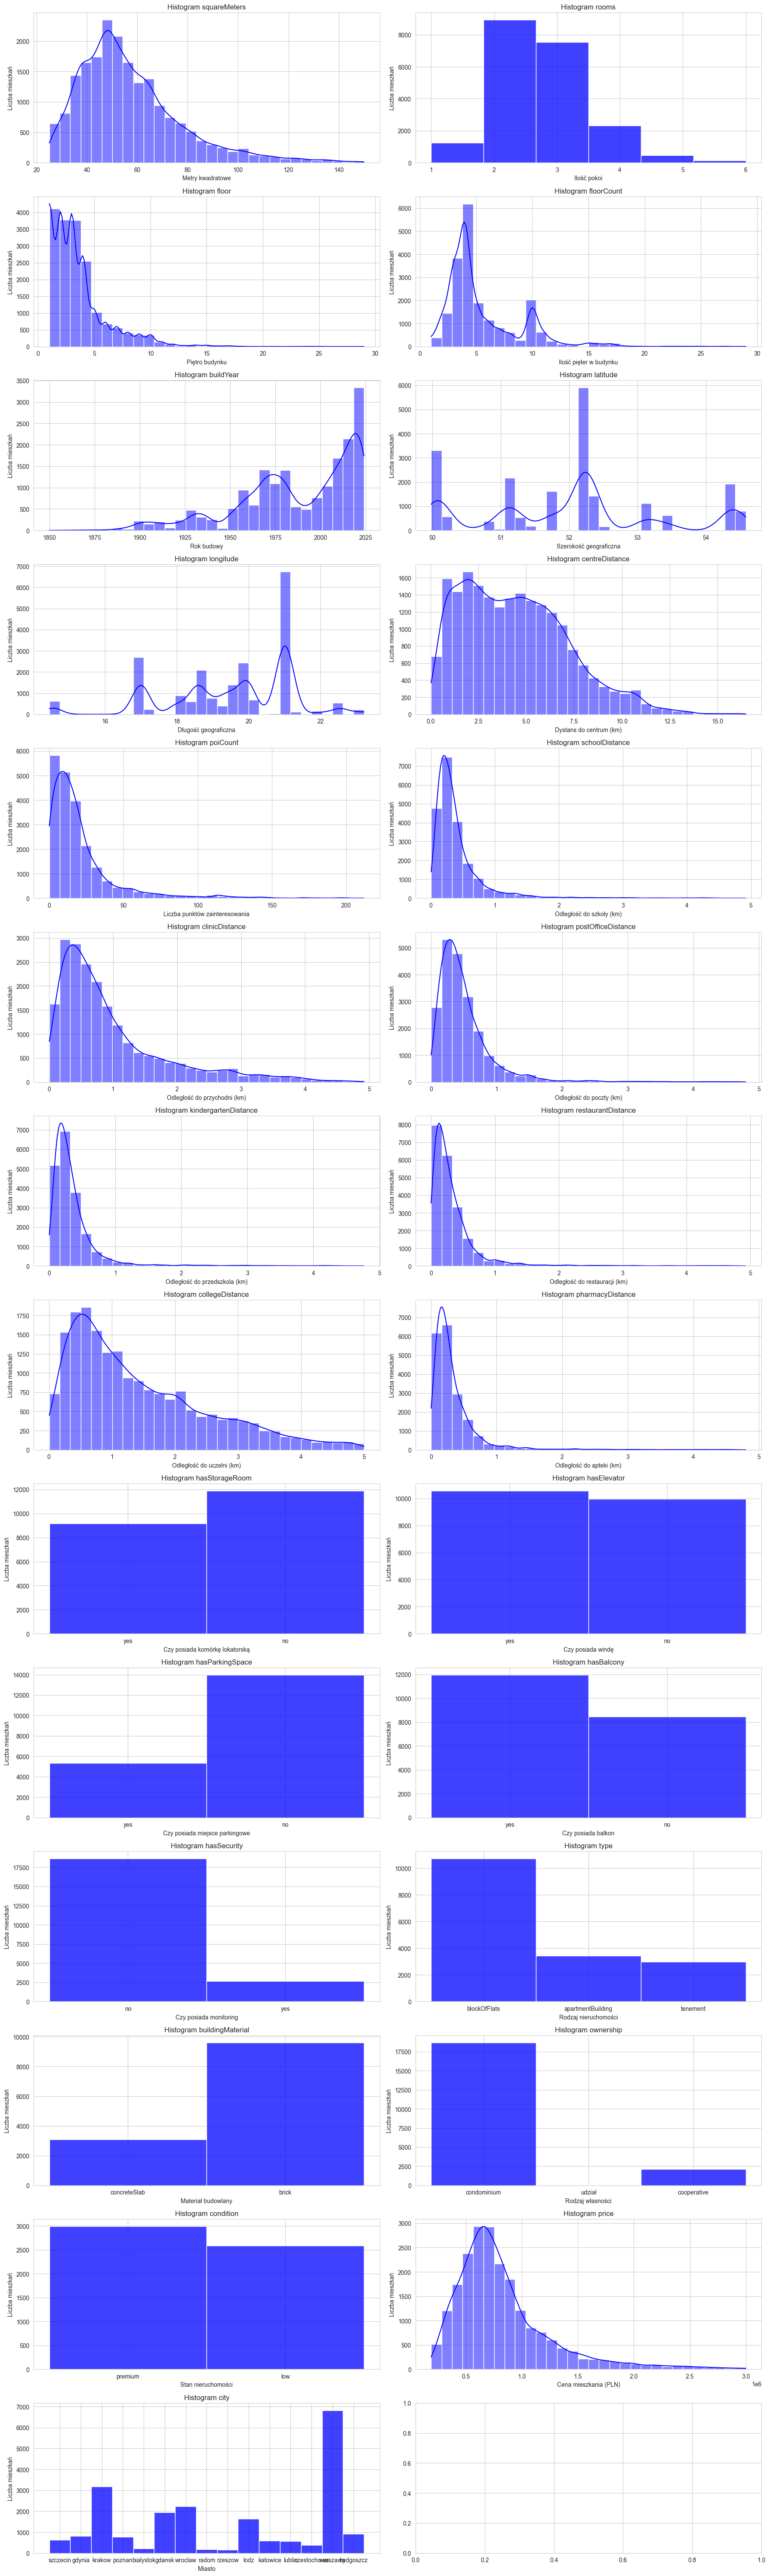

In [5]:
def create_hist_plot(index, data, column, axes, xlabel=None, ylabel="Liczba mieszkań", color="blue", bins=30, kde=True):
    sns.histplot(data[column], bins=bins, kde=kde, color=color, ax=axes[index])
    axes[index].set_title(f"Histogram {column}")
    axes[index].set_xlabel(xlabel)
    axes[index].set_ylabel(ylabel)


fig, axes = plt.subplots(14, 2, figsize=(18, 60))
axes = axes.flatten()

create_hist_plot(0, apartments_data, "squareMeters", axes, xlabel="Metry kwadratowe")
create_hist_plot(1, apartments_data, "rooms", axes, xlabel="Ilość pokoi", bins=6, kde=False)
create_hist_plot(2, apartments_data, "floor", axes, xlabel="Piętro budynku")
create_hist_plot(3, apartments_data, "floorCount", axes, xlabel="Ilość pięter w budynku")
create_hist_plot(4, apartments_data, "buildYear", axes, xlabel="Rok budowy")
create_hist_plot(5, apartments_data, "latitude", axes, xlabel="Szerokość geograficzna")
create_hist_plot(6, apartments_data, "longitude", axes, xlabel="Długość geograficzna")
create_hist_plot(7, apartments_data, "centreDistance", axes, xlabel="Dystans do centrum (km)")
create_hist_plot(8, apartments_data, "poiCount", axes, xlabel="Liczba punktów zainteresowania")
create_hist_plot(9, apartments_data, "schoolDistance", axes, xlabel="Odległość do szkoły (km)")
create_hist_plot(10, apartments_data, "clinicDistance", axes, xlabel="Odległość do przychodni (km)")
create_hist_plot(11, apartments_data, "postOfficeDistance", axes, xlabel="Odległość do poczty (km)")
create_hist_plot(12, apartments_data, "kindergartenDistance", axes, xlabel="Odległość do przedszkola (km)")
create_hist_plot(13, apartments_data, "restaurantDistance", axes, xlabel="Odległość do restauracji (km)")
create_hist_plot(14, apartments_data, "collegeDistance", axes, xlabel="Odległość do uczelni (km)")
create_hist_plot(15, apartments_data, "pharmacyDistance", axes, xlabel="Odległość do apteki (km)")
create_hist_plot(16, apartments_data, "hasStorageRoom", axes, xlabel="Czy posiada komórkę lokatorską", kde=False)
create_hist_plot(17, apartments_data, "hasElevator", axes, xlabel="Czy posiada windę", kde=False)
create_hist_plot(18, apartments_data, "hasParkingSpace", axes, xlabel="Czy posiada miejsce parkingowe", kde=False)
create_hist_plot(19, apartments_data, "hasBalcony", axes, xlabel="Czy posiada balkon", kde=False)
create_hist_plot(20, apartments_data, "hasSecurity", axes, xlabel="Czy posiada monitoring", kde=False)
create_hist_plot(21, apartments_data, "type", axes, xlabel="Rodzaj nieruchomości", kde=False)
create_hist_plot(22, apartments_data, "buildingMaterial", axes, xlabel="Materiał budowlany", kde=False)
create_hist_plot(23, apartments_data, "ownership", axes, xlabel="Rodzaj własności", kde=False)
create_hist_plot(24, apartments_data, "condition", axes, xlabel="Stan nieruchomości", kde=False)
create_hist_plot(25, apartments_data, "price", axes, xlabel="Cena mieszkania (PLN)")
create_hist_plot(26, apartments_data, "city", axes, xlabel="Miasto", kde=False)

plt.tight_layout()
plt.show()

1. Metraż mieszkań - Większość mieszkań na rynku ma powierzchnię między 40 a 70 m², ze średnią wynoszącą około 57 m². Widoczna jest asymetria rozkładu w stronę mniejszych mieszkań.
2. Liczba pokoi - Dominują mieszkania 2 i 3 pokojowe, które stanowią największą część oferty rynkowej.
3. Piętro - Najczęściej spotykane są mieszkania na 1-4 piętrze. 
4. Ilość pięter w budynku - Przeważają budynki 4-piętrowe, choć rozkład jest zróżnicowany.
5. Rok budowy - Zauważalny jest wyraźny dwumodalny rozkład z dwoma szczytami: jeden dla budynków z lat 1970-1980 (okres PRL) i drugi dla nowych inwestycji po 2000 roku
6. Cena - Rozkład cen jest asymetryczny, z przewagą mieszkań w przedziale 500-900k pln.
7. Czy poisada miejsce parkingowe - Większość nieruchmości nie posiada miejsca parkingowego
8. Czy posiada windę - Co druga nieruchomość posiada windę
9. Material budowlany - 70% nieruchomości wykonana jest z cegly, pozostala z betonowej plyty.
10. Rodzaj nieruchomości - Dominują mieszkania w bloku / kamienicy

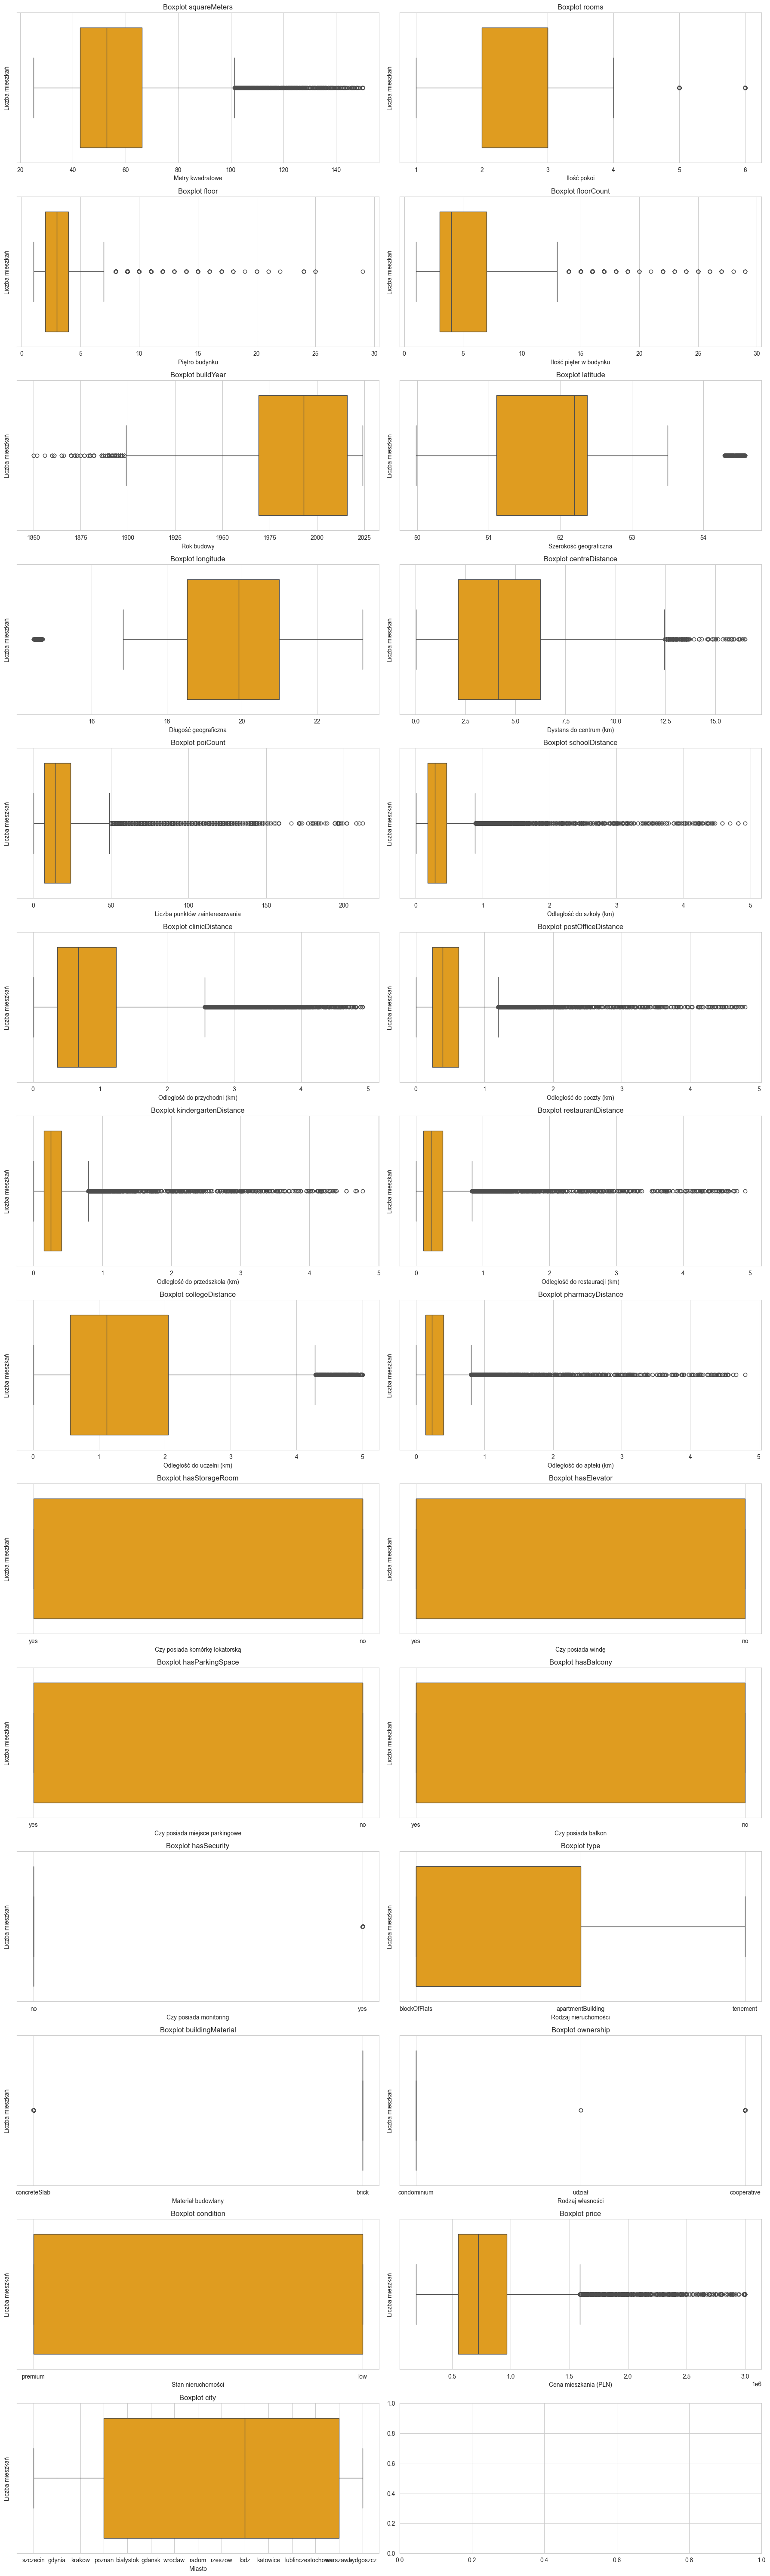

In [6]:
def create_box_plot(index, data, column, axes, xlabel=None, ylabel="Liczba mieszkań", color="orange"):
    sns.boxplot(data[column], color=color, ax=axes[index], orient='h')
    axes[index].set_title(f"Boxplot {column}")
    axes[index].set_xlabel(xlabel)
    axes[index].set_ylabel(ylabel)


fig, axes = plt.subplots(14, 2, figsize=(18, 60))
axes = axes.flatten()

create_box_plot(0, apartments_data, "squareMeters", axes, xlabel="Metry kwadratowe")
create_box_plot(1, apartments_data, "rooms", axes, xlabel="Ilość pokoi")
create_box_plot(2, apartments_data, "floor", axes, xlabel="Piętro budynku")
create_box_plot(3, apartments_data, "floorCount", axes, xlabel="Ilość pięter w budynku")
create_box_plot(4, apartments_data, "buildYear", axes, xlabel="Rok budowy")
create_box_plot(5, apartments_data, "latitude", axes, xlabel="Szerokość geograficzna")
create_box_plot(6, apartments_data, "longitude", axes, xlabel="Długość geograficzna")
create_box_plot(7, apartments_data, "centreDistance", axes, xlabel="Dystans do centrum (km)")
create_box_plot(8, apartments_data, "poiCount", axes, xlabel="Liczba punktów zainteresowania")
create_box_plot(9, apartments_data, "schoolDistance", axes, xlabel="Odległość do szkoły (km)")
create_box_plot(10, apartments_data, "clinicDistance", axes, xlabel="Odległość do przychodni (km)")
create_box_plot(11, apartments_data, "postOfficeDistance", axes, xlabel="Odległość do poczty (km)")
create_box_plot(12, apartments_data, "kindergartenDistance", axes, xlabel="Odległość do przedszkola (km)")
create_box_plot(13, apartments_data, "restaurantDistance", axes, xlabel="Odległość do restauracji (km)")
create_box_plot(14, apartments_data, "collegeDistance", axes, xlabel="Odległość do uczelni (km)")
create_box_plot(15, apartments_data, "pharmacyDistance", axes, xlabel="Odległość do apteki (km)")
create_box_plot(16, apartments_data, "hasStorageRoom", axes, xlabel="Czy posiada komórkę lokatorską")
create_box_plot(17, apartments_data, "hasElevator", axes, xlabel="Czy posiada windę")
create_box_plot(18, apartments_data, "hasParkingSpace", axes, xlabel="Czy posiada miejsce parkingowe")
create_box_plot(19, apartments_data, "hasBalcony", axes, xlabel="Czy posiada balkon")
create_box_plot(20, apartments_data, "hasSecurity", axes, xlabel="Czy posiada monitoring")
create_box_plot(21, apartments_data, "type", axes, xlabel="Rodzaj nieruchomości")
create_box_plot(22, apartments_data, "buildingMaterial", axes, xlabel="Materiał budowlany")
create_box_plot(23, apartments_data, "ownership", axes, xlabel="Rodzaj własności")
create_box_plot(24, apartments_data, "condition", axes, xlabel="Stan nieruchomości")
create_box_plot(25, apartments_data, "price", axes, xlabel="Cena mieszkania (PLN)")
create_box_plot(26, apartments_data, "city", axes, xlabel="Miasto")

plt.tight_layout()
plt.show()



Wnioski z owych wykresów są tożsame z tymi spod histogramów.

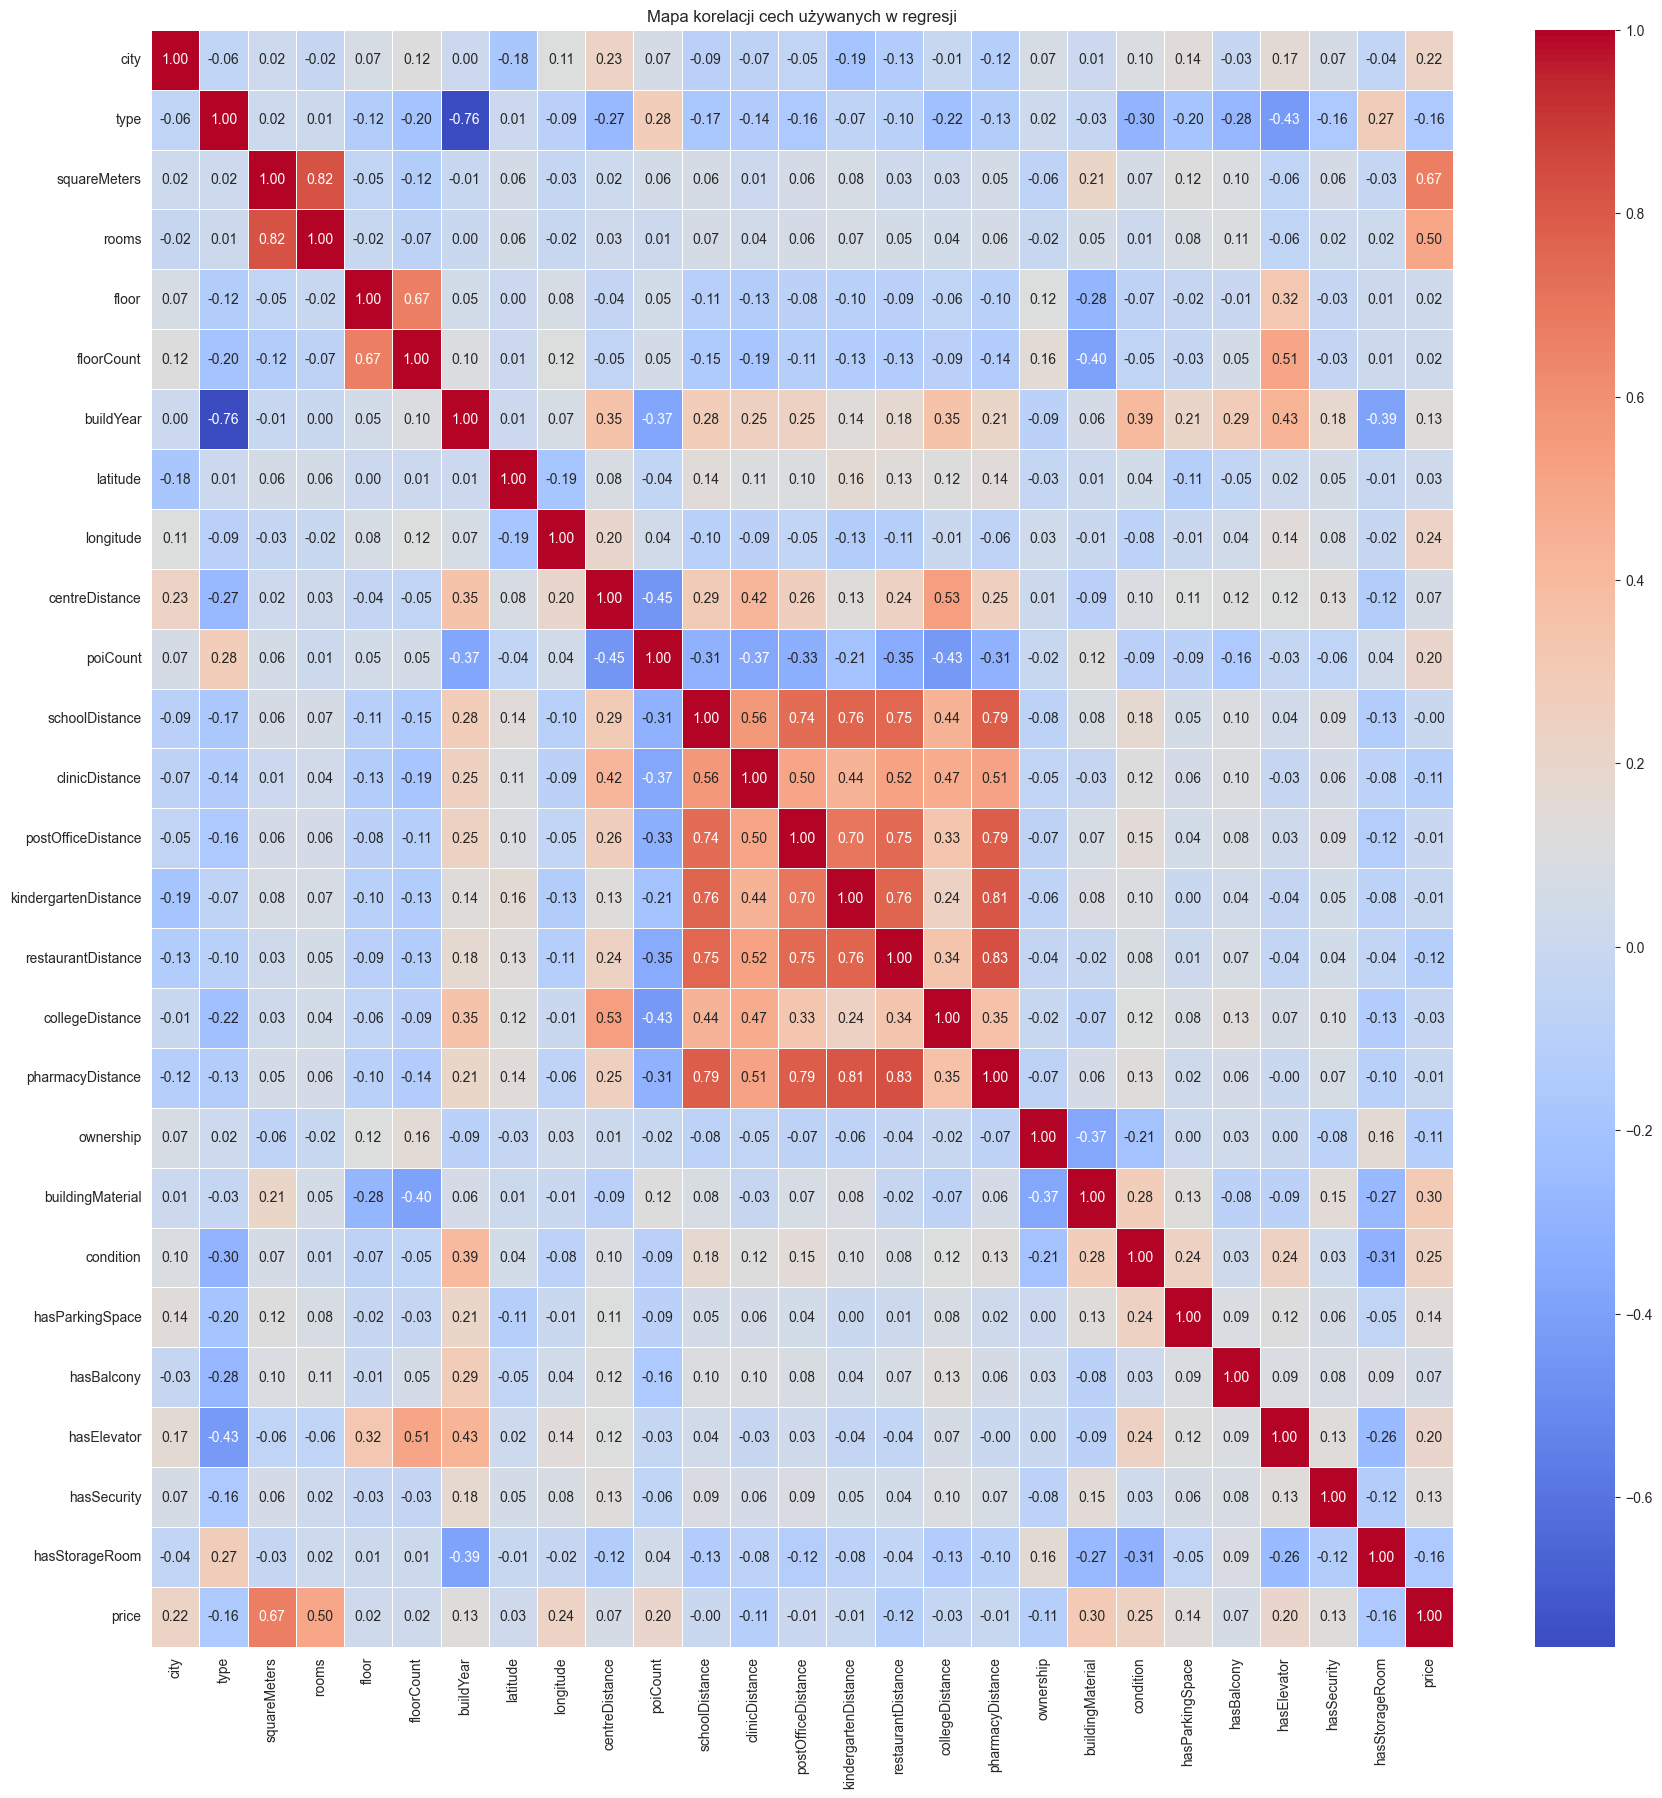

In [7]:
filtered_data = apartments_data[selected_columns].copy()

filtered_data["hasElevator"] = filtered_data["hasElevator"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["hasParkingSpace"] = filtered_data["hasParkingSpace"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["type"] = filtered_data["type"].map({"blockOfFlats": 1, "apartmentBuilding": 0, "tenement": 2}).astype(
    "Int64")
filtered_data["hasStorageRoom"] = filtered_data["hasStorageRoom"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["buildingMaterial"] = filtered_data["buildingMaterial"].map({"brick": 1, "concreteSlab": 0}).astype(
    "Int64")
filtered_data["hasBalcony"] = filtered_data["hasBalcony"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["hasSecurity"] = filtered_data["hasSecurity"].map({"yes": 1, "no": 0}).astype("Int64")

filtered_data["ownership"] = filtered_data["ownership"].map({
    "condominium": 0,
    "cooperative": 1,
    "udział": 2
}).astype("Int64")

filtered_data["condition"] = filtered_data["condition"].map({
    "low": 0,
    "premium": 1
}).astype("Int64")

filtered_data["city"] = filtered_data["city"].astype("category").cat.codes

corr_matrix = filtered_data.corr(method='pearson')

plt.figure(figsize=(21, 21))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa korelacji cech używanych w regresji")
plt.show()

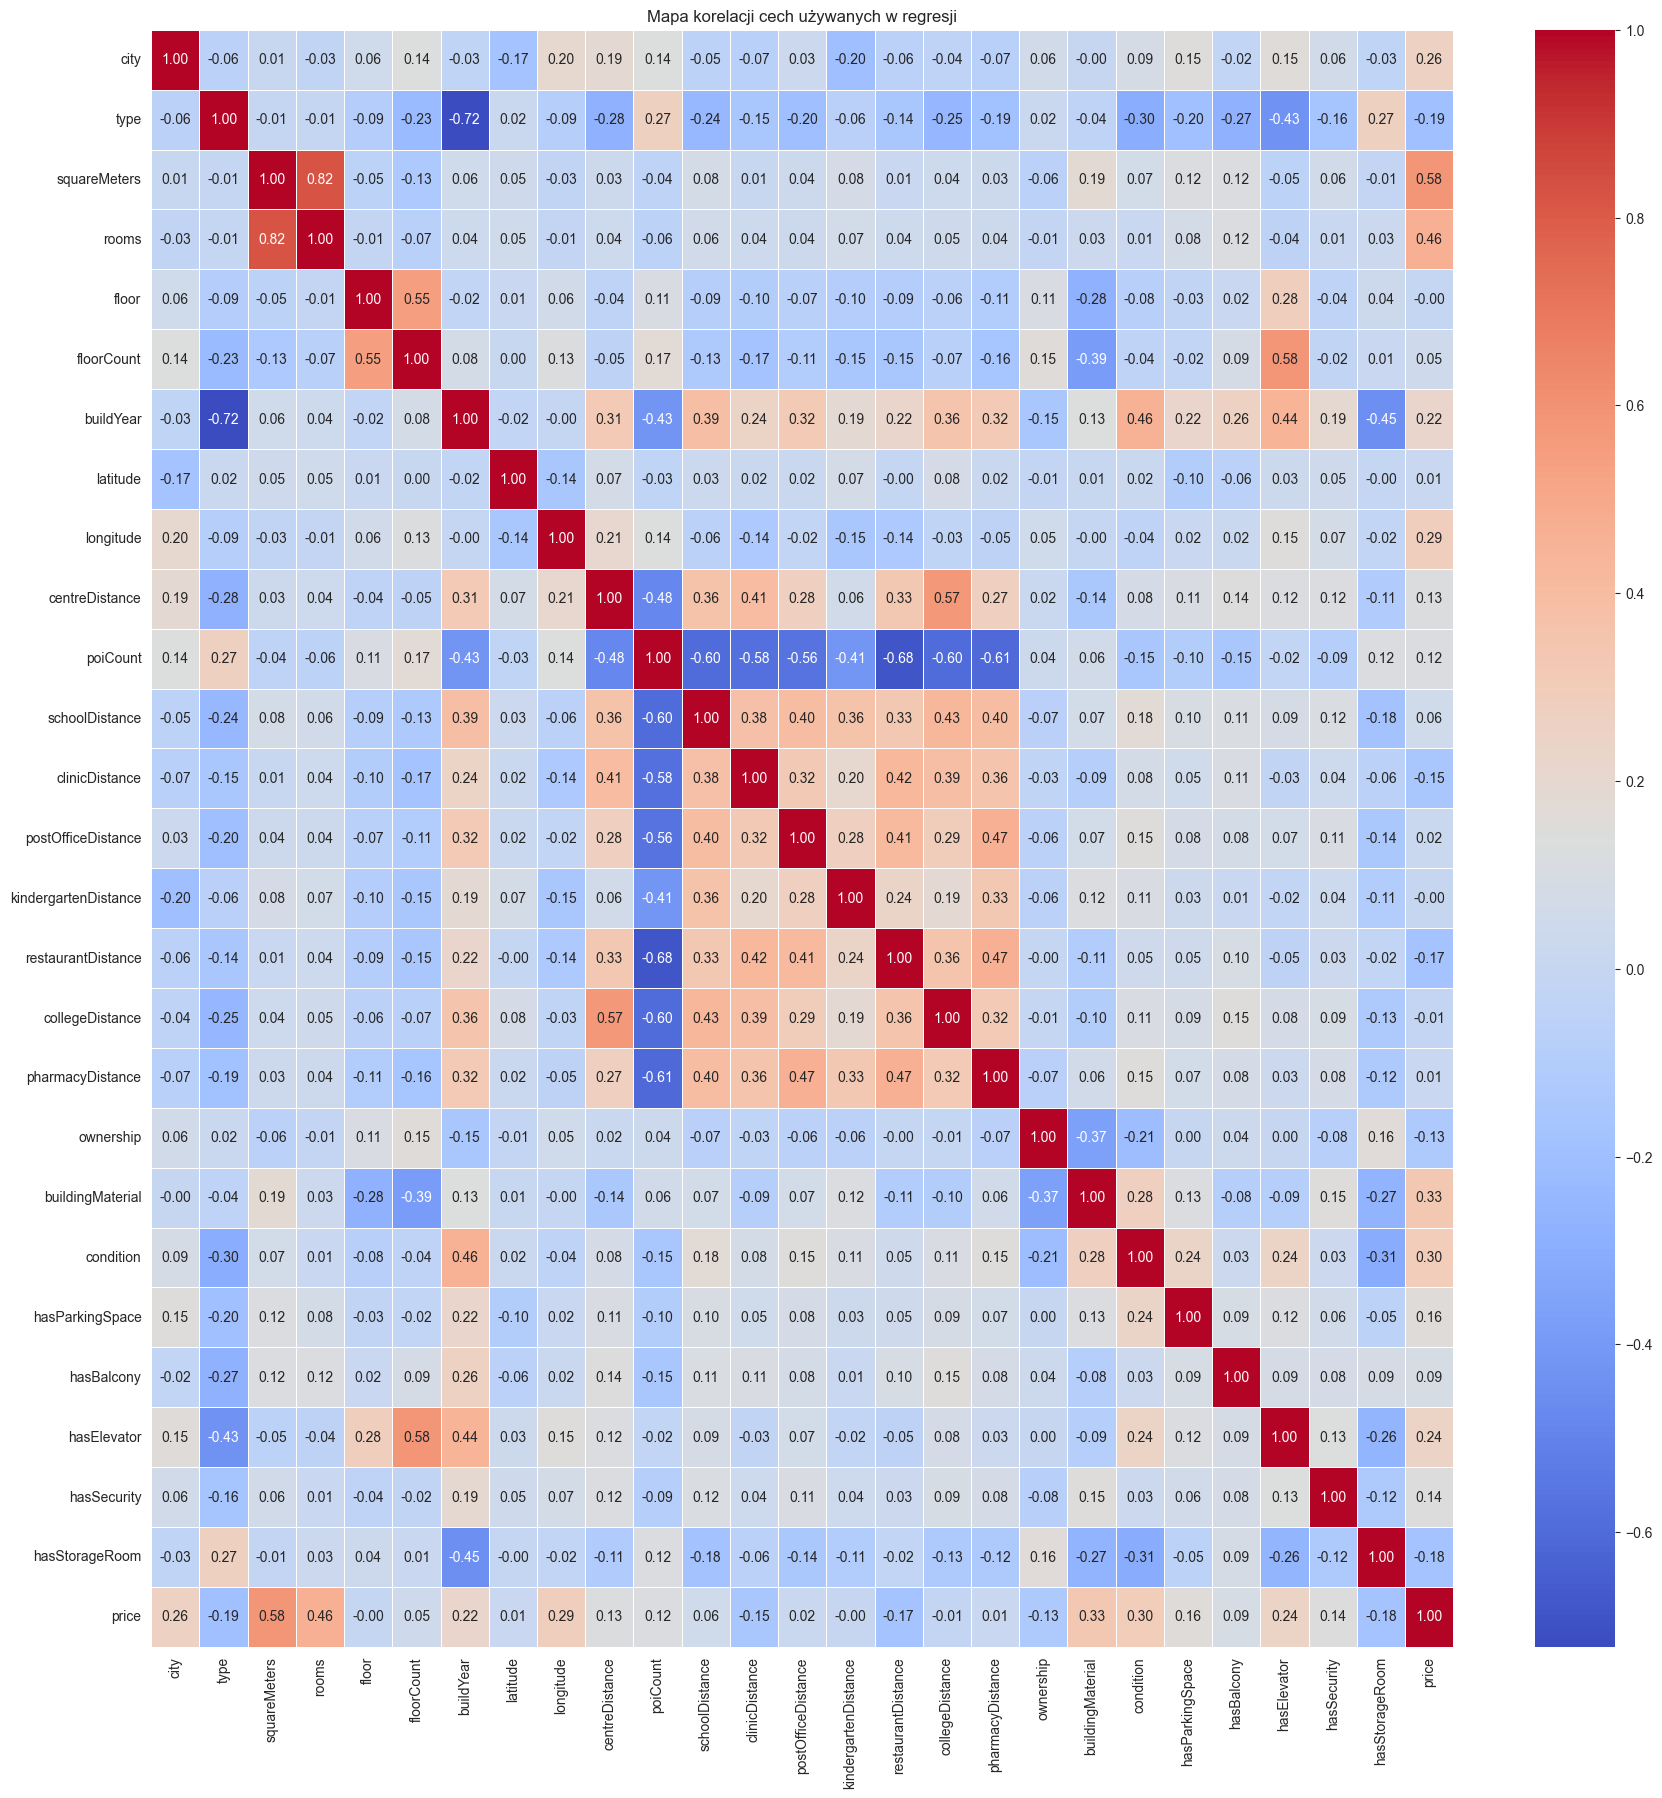

In [8]:
corr_matrix = filtered_data.corr(method='spearman')

plt.figure(figsize=(21, 21))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa korelacji cech używanych w regresji")
plt.show()

Wnioski:
1. Metraż i liczba pokoi - Najsilniejsza korelacja w obu metodach (Pearson: 0.82, Spearman: 0.82)
   - Zależność ta jest oczywista i potwierdza, że większe mieszkania posiadają więcej pokoi.

2. Metraż i cena - Bardzo silna korelacja (Pearson: 0.67, Spearman: 0.59)
   - Potwierdza, że powierzchnia mieszkania jest kluczowym czynnikiem wpływającym na jego cenę.

3. Liczba pięter w budynku i obecność windy - Silna korelacja (Pearson: 0.51, Spearman: 0.58)
   - Im wyższy budynek, tym większe prawdopodobieństwo, że posiada windę.

4. Piętro i liczba pięter w budynku - Silna korelacja (Pearson: 0.67, Spearman: 0.55)
   - Mieszkania na wyższych piętrach znajdują się częściej w wyższych budynkach.

5. Rok budowy i obecność windy - Wyraźna korelacja (Pearson: 0.43, Spearman: 0.44)
   - Nowsze budynki częściej wyposażone są w windy.

6. Liczba pokoi i cena - Znacząca korelacja (Pearson: 0.50, Spearman: 0.46)
   - Potwierdza wpływ liczby pokoi na cenę mieszkania.


In [9]:
avg_prices = apartments_data[['city', 'price']].copy().groupby('city')['price'].agg(['mean', 'count']).reset_index()

avg_prices.columns = ['City', 'Average Price', 'Number of properties']

avg_prices['Average Price'] = avg_prices['Average Price'].round(0).astype(int)

avg_prices = avg_prices.sort_values('Average Price', ascending=False)
avg_prices

,City,Average Price,Number of properties
13,warszawa,1052673,6827
6,krakow,942313,3173
3,gdansk,891648,1952
4,gdynia,888045,810
14,wroclaw,746410,2231
9,poznan,646691,776
11,rzeszow,633849,159
8,lublin,580949,566
12,szczecin,572942,637
5,katowice,527228,584


Jak można zauważyć na powyższym zestawieniu najwyższa średnia cena transakcyjna występuje w stolicy polski i wynosi: 1,053,134 pln. Na drugim miejscu plasuje się Kraków z średnią ceną niższą o 110 tys. pln niż Warszawa tj. 942,169 pln

In [10]:
import folium
from folium.plugins import HeatMap

cracow_df = apartments_data[apartments_data['city'] == 'krakow'].copy()
cracow_df = cracow_df.dropna(subset=['latitude', 'longitude'])

center_lat = cracow_df['latitude'].mean()
center_lng = cracow_df['longitude'].mean()

points = cracow_df[['latitude', 'longitude']].values.tolist()

cracow_map = folium.Map(location=[center_lat, center_lng], zoom_start=12)

HeatMap(points).add_to(cracow_map)

cracow_map

Mapa cieplna przedstawia geograficzny rozkład ofert nieruchomości w Krakowie, ukazując ich koncentrację w poszczególnych częściach miasta. Najwyższa gęstość ofert znajduje się w centrum, co wskazuje na duże zapotrzebowanie na nieruchomości w tej lokalizacji. Dzielnice takie jak Stare Miasto i Kazimierz cieszą się szczególną popularnością. Mniejsza liczba ofert na obrzeżach Krakowa wskazuje na niższe zainteresowanie lub ograniczoną podaż w tych rejonach.

### Wypelnienie KNN

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

knn_data = apartments_data.copy()
knn_data = knn_data.replace({None: np.nan, 'None': np.nan})

cat_cols = knn_data.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = knn_data.select_dtypes(include=['number']).columns.tolist()

encoders = {}
impute_knn_data = knn_data.copy()

for col in cat_cols:
    le = LabelEncoder()

    non_null_values = knn_data[col].dropna().astype(str).values
    le.fit(non_null_values)

    impute_knn_data.loc[knn_data[col].notna(), col] = le.transform(knn_data.loc[knn_data[col].notna(), col].astype(str))
    encoders[col] = le

knn = KNNImputer(n_neighbors=5)
imputed_values = knn.fit_transform(impute_knn_data)

knn_data = pd.DataFrame(imputed_values, columns=knn_data.columns)

for col in cat_cols:
    le = encoders[col]
    knn_data[col] = np.round(knn_data[col]).astype(int)
    knn_data[col] = np.clip(knn_data[col], 0, len(le.classes_) - 1)
    knn_data[col] = le.inverse_transform(knn_data[col].astype(int))

knn_data[cat_cols] = knn_data[cat_cols].astype('category')

knn_data

,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,szczecin,blockOfFlats,47.00,1.8,6.0,12.0,1981.0,53.428544,14.552812,0.79,67.0,0.288,0.285,0.268,0.2450,0.068,0.5930,0.139,condominium,concreteSlab,premium,no,yes,yes,no,yes,449000.0
1,szczecin,apartmentBuilding,88.22,3.0,1.0,2.0,2000.0,53.449093,14.516844,4.09,0.0,0.509,1.039,0.998,0.6760,0.661,1.1920,0.387,condominium,brick,premium,yes,yes,no,no,no,950000.0
2,szczecin,apartmentBuilding,117.00,5.0,4.0,4.0,1987.6,53.443096,20.312819,2.19,10.0,0.216,0.611,0.743,0.2800,0.298,1.6360,0.229,udział,brick,premium,yes,yes,no,no,no,1099000.0
3,szczecin,blockOfFlats,33.31,1.0,1.0,4.0,1963.0,53.436100,14.541200,1.93,39.0,0.073,0.326,0.284,0.0890,0.180,0.0410,0.388,cooperative,brick,low,yes,no,no,yes,yes,380000.0
4,szczecin,blockOfFlats,56.00,3.0,7.0,7.0,2018.0,53.447465,14.557811,2.68,10.0,0.268,0.771,0.676,0.2830,0.322,1.6430,0.178,condominium,brick,premium,yes,yes,yes,yes,yes,799000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21496,bydgoszcz,blockOfFlats,54.00,3.0,4.0,4.0,1974.0,51.767102,18.045220,3.01,16.0,0.325,0.599,0.201,0.1022,0.111,0.6140,0.062,condominium,brick,premium,no,yes,no,no,yes,460000.0
21497,bydgoszcz,tenement,98.00,3.0,3.2,2.0,1925.0,53.124655,18.008459,0.59,49.0,0.113,0.226,0.225,0.4120,0.124,0.4780,0.273,condominium,brick,low,no,no,no,no,yes,499000.0
21498,bydgoszcz,tenement,108.96,5.0,2.0,4.0,1889.0,53.131748,18.000648,1.08,28.0,0.281,0.792,0.233,0.1760,0.107,0.2260,0.143,condominium,brick,low,no,no,no,no,yes,795000.0
21499,bydgoszcz,blockOfFlats,50.12,2.0,1.0,1.0,1953.4,53.129657,18.003888,0.88,42.0,0.174,0.496,0.388,0.4600,0.079,0.7058,0.250,condominium,brick,low,yes,no,no,no,no,360000.0


### Wypelnienie średnią wartością

In [12]:
mean_data = apartments_data.copy()
mean_data = mean_data.replace({None: np.nan, 'None': np.nan})

cat_cols = mean_data.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = mean_data.select_dtypes(include=['number']).columns.tolist()

for col in numeric_cols:
    mean_value = mean_data[col].mean()
    mean_data[col].fillna(mean_value, inplace=True)

for col in cat_cols:
    mode_value = mean_data[col].mode()[0]
    mean_data[col].fillna(mode_value, inplace=True)

mean_data[cat_cols] = mean_data[cat_cols].astype('category')

mean_data

/var/folders/3d/q2hrtkpd4n9d2g8ry1gh3j940000gn/T/ipykernel_29389/2630931095.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mean_data[col].fillna(mean_value, inplace=True)
/var/folders/3d/q2hrtkpd4n9d2g8ry1gh3j940000gn/T/ipykernel_29389/2630931095.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,szczecin,blockOfFlats,47.00,2.624485,6.000000,12.0,1981.000000,53.428544,14.552812,0.79,67.0,0.288,0.285,0.268,0.245000,0.068,0.593000,0.346341,condominium,concreteSlab,premium,no,yes,yes,no,yes,449000
1,szczecin,apartmentBuilding,88.22,3.000000,1.000000,2.0,2000.000000,53.449093,14.516844,4.09,0.0,0.509,1.039,0.998,0.676000,0.661,1.192000,0.346341,condominium,brick,premium,yes,yes,no,no,no,950000
2,szczecin,apartmentBuilding,117.00,5.000000,4.000000,4.0,1986.774129,53.443096,19.503088,2.19,10.0,0.216,0.611,0.743,0.280000,0.298,1.442924,0.229000,udział,brick,premium,yes,yes,no,no,no,1099000
3,szczecin,blockOfFlats,33.31,1.000000,1.000000,4.0,1963.000000,53.436100,14.541200,1.93,39.0,0.073,0.326,0.284,0.089000,0.180,0.041000,0.388000,cooperative,brick,premium,yes,no,no,yes,yes,380000
4,szczecin,blockOfFlats,56.00,3.000000,7.000000,7.0,2018.000000,53.447465,14.557811,2.68,10.0,0.268,0.771,0.676,0.357135,0.322,1.643000,0.178000,condominium,brick,premium,yes,yes,yes,yes,yes,799000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21496,bydgoszcz,blockOfFlats,54.00,3.000000,4.000000,4.0,1986.774129,51.990994,18.045220,3.01,16.0,0.325,0.599,0.201,0.357135,0.111,0.614000,0.062000,condominium,brick,premium,no,yes,no,no,yes,460000
21497,bydgoszcz,tenement,98.00,3.000000,3.404786,2.0,1925.000000,53.124655,18.008459,0.59,49.0,0.113,0.226,0.225,0.412000,0.124,0.478000,0.273000,condominium,brick,premium,no,yes,no,no,yes,499000
21498,bydgoszcz,tenement,108.96,5.000000,2.000000,4.0,1889.000000,53.131748,18.000648,1.08,28.0,0.281,0.792,0.233,0.176000,0.107,0.226000,0.143000,condominium,brick,premium,no,no,no,no,yes,795000
21499,bydgoszcz,blockOfFlats,50.12,2.000000,1.000000,1.0,1986.774129,53.129657,18.003888,0.88,42.0,0.174,0.496,0.388,0.460000,0.079,1.442924,0.250000,condominium,brick,premium,yes,no,no,no,no,360000


### Wypelnienie losową wartością

In [13]:
random_data = apartments_data.copy()
random_data = random_data.replace({None: np.nan, 'None': np.nan})

cat_cols = random_data.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = random_data.select_dtypes(include=['number']).columns.tolist()

for col in numeric_cols:
    valid_values = random_data.loc[random_data[col].notna(), col].values

    missing_indices = random_data[col].isna()

    if sum(missing_indices) > 0 and len(valid_values) > 0:
        random_fills = np.random.choice(valid_values, size=sum(missing_indices))
        random_data.loc[missing_indices, col] = random_fills

for col in cat_cols:
    valid_values = random_data.loc[random_data[col].notna(), col].values

    missing_indices = random_data[col].isna()

    if sum(missing_indices) > 0 and len(valid_values) > 0:
        random_fills = np.random.choice(valid_values, size=sum(missing_indices))
        random_data.loc[missing_indices, col] = random_fills

random_data[cat_cols] = random_data[cat_cols].astype('category')

random_data

,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,szczecin,blockOfFlats,47.00,3.0,6.0,12.0,1981.0,53.428544,14.552812,0.79,67.0,0.288,0.285,0.268,0.245,0.068,0.593,0.106,condominium,concreteSlab,low,yes,yes,yes,no,yes,449000
1,szczecin,apartmentBuilding,88.22,3.0,1.0,2.0,2000.0,53.449093,14.516844,4.09,0.0,0.509,1.039,0.998,0.676,0.661,1.192,0.146,condominium,brick,premium,yes,yes,no,no,no,950000
2,szczecin,apartmentBuilding,117.00,5.0,4.0,4.0,1955.0,53.443096,21.125390,2.19,10.0,0.216,0.611,0.743,0.280,0.298,2.346,0.229,udział,brick,premium,yes,yes,no,no,no,1099000
3,szczecin,blockOfFlats,33.31,1.0,1.0,4.0,1963.0,53.436100,14.541200,1.93,39.0,0.073,0.326,0.284,0.089,0.180,0.041,0.388,cooperative,brick,premium,yes,no,no,yes,yes,380000
4,szczecin,blockOfFlats,56.00,3.0,7.0,7.0,2018.0,53.447465,14.557811,2.68,10.0,0.268,0.771,0.676,0.054,0.322,1.643,0.178,condominium,brick,premium,yes,yes,yes,yes,yes,799000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21496,bydgoszcz,blockOfFlats,54.00,3.0,4.0,4.0,2009.0,52.282530,18.045220,3.01,16.0,0.325,0.599,0.201,0.223,0.111,0.614,0.062,condominium,brick,premium,no,yes,no,no,yes,460000
21497,bydgoszcz,tenement,98.00,3.0,9.0,2.0,1925.0,53.124655,18.008459,0.59,49.0,0.113,0.226,0.225,0.412,0.124,0.478,0.273,condominium,brick,premium,no,yes,no,no,yes,499000
21498,bydgoszcz,tenement,108.96,5.0,2.0,4.0,1889.0,53.131748,18.000648,1.08,28.0,0.281,0.792,0.233,0.176,0.107,0.226,0.143,condominium,brick,low,no,no,no,no,yes,795000
21499,bydgoszcz,tenement,50.12,2.0,1.0,1.0,1980.0,53.129657,18.003888,0.88,42.0,0.174,0.496,0.388,0.460,0.079,0.286,0.250,condominium,brick,low,yes,no,no,no,no,360000


### Podzial na zbiór treningowy i testowy

In [14]:
X = apartments_data.iloc[:, :-1]
Y = apartments_data.iloc[:, -1]

In [15]:
def split_set_into_training(
        X: pd.DataFrame,
        Y: pd.DataFrame,
        training_size_percentage: float,
        random_state: int = 2137
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X_shuffled = X.sample(frac=1.0, random_state=random_state)
    Y_shuffled = Y.reindex(X_shuffled.index)

    n_train = int(training_size_percentage * len(X_shuffled))

    X_train = X_shuffled.iloc[:n_train]
    Y_train = Y_shuffled.iloc[:n_train]
    X_test = X_shuffled.iloc[n_train:]
    Y_test = Y_shuffled.iloc[n_train:]

    return X_train, Y_train, X_test, Y_test


In [16]:
def split_set_into_cross_validation(X: pd.DataFrame, Y: pd.DataFrame, n_splits: int = 5, random_state: int = 2137) -> \
        tuple[
            pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    indices = pd.Series(X.index).sample(frac=1.0, random_state=random_state).tolist()
    n_samples = len(indices)
    fold_sizes = [n_samples // n_splits + (1 if i < n_samples % n_splits else 0) for i in range(n_splits)]

    folds = []
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_idx = indices[start:stop]
        train_idx = indices[:start] + indices[stop:]

        X_train = X.loc[train_idx]
        Y_train = Y.loc[train_idx]
        X_test = X.loc[test_idx]
        Y_test = Y.loc[test_idx]

        folds.append((X_train, Y_train, X_test, Y_test))
        current = stop

    return folds


folds = split_set_into_cross_validation(X, Y, n_splits=5, random_state=42)
X_train, Y_train, X_test, Y_test = folds[1]
X_train_2, _, _, _ = folds[0]
print("X_train size: ", X_train.shape[0])
print("Y_train size: ", Y_train.shape[0])
print("X_test size: ", X_test.shape[0])
print("Y_Test size: ", Y_test.shape[0])
print(f'size of X: {X.shape[0]}')
print(f'size of Y: {Y.shape[0]}')

print(np.array_equal(X_train, X_train_2))

X_train size:  17201
Y_train size:  17201
X_test size:  4300
Y_Test size:  4300
size of X: 21501
size of Y: 21501
False


### Skalowanie minmax i standaryzacja

In [17]:
def apply_standard_scaling(X):
    scaled_df = X.copy()
    numeric_cols = X.select_dtypes(include=['number']).columns
    scaling_params = {}

    for col in numeric_cols:
        mean_val = X[col].mean()
        std_val = X[col].std()

        if std_val == 0:
            scaled_df[col] = 0
        else:
            scaled_df[col] = (X[col] - mean_val) / std_val

        scaling_params[col] = {'mean': mean_val, 'std': std_val}

    return scaled_df, scaling_params


def apply_minmax_scaling(X):
    scaled_X = X.copy()
    numeric_cols = X.select_dtypes(include=['number']).columns
    scaling_params = {}

    for col in numeric_cols:
        min_val = X[col].min()
        max_val = X[col].max()

        if max_val == min_val:
            scaled_X[col] = 0.5
        else:
            scaled_X[col] = (X[col] - min_val) / (max_val - min_val)

        scaling_params[col] = {'min': min_val, 'max': max_val}

    return scaled_X, scaling_params

In [18]:
# IDK Czy to nie powinno byc tak zeby pozniej tez przeskalowac zbior testowy
# def apply_standard_scaling(X: pd.DataFrame):
#     numeric_cols = X.select_dtypes(include=['number']).columns
#     scaler = StandardScaler()

#     scaled_values = scaler.fit_transform(X[numeric_cols])
#     scaled_df = X.copy()
#     scaled_df[numeric_cols] = scaled_values

#     return scaled_df, scaler

# def apply_minmax_scaling(X: pd.DataFrame):
#     numeric_cols = X.select_dtypes(include=['number']).columns
#     scaler = MinMaxScaler()

#     scaled_values = scaler.fit_transform(X[numeric_cols])
#     scaled_df = X.copy()
#     scaled_df[numeric_cols] = scaled_values

#     return scaled_df, scaler

### Wszystkie zbiory danych

In [19]:
knn_features = knn_data.copy().iloc[:, :-1]
knn_target = knn_data.copy().iloc[:, -1]

# knn min-max
knn_minmax_features, knn_minmax_params = apply_minmax_scaling(knn_features)

# knn standardized
knn_standardize_features, knn_standardize_params = apply_standard_scaling(knn_features)

In [20]:
mean_features = mean_data.copy().iloc[:, :-1]
mean_target = mean_data.copy().iloc[:, -1]

# mean min-max
mean_minmax_features, mean_minmax_params = apply_minmax_scaling(mean_features)

# mean standardized
mean_standardize_features, mean_standardize_params = apply_standard_scaling(mean_features)

In [21]:
random_features = random_data.copy().iloc[:, :-1]
random_target = random_data.copy().iloc[:, -1]

# random min-max
random_minmax_features, random_minmax_params = apply_minmax_scaling(random_features)

# random standardized
random_standardize_features, random_standardize_params = apply_standard_scaling(random_features)

### Trenowanie modeli

In [22]:
def root_mean_squared_error(model, X, y) -> float:
    predictions = model.predict(X)
    predictions = np.asarray(predictions).ravel()
    y_true = np.asarray(y).ravel()
    return np.sqrt(((predictions - y_true) ** 2).mean())


### XGBoost

In [23]:
def train_xgboost(X: pd.DataFrame, y: pd.DataFrame) -> float:
    xgb = XGBRegressor(
        use_label_encoder=True,
        enable_categorical=True,
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=2137
    )
    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)
    xgb.fit(x_train, y_train)

    return root_mean_squared_error(xgb, x_test, y_test)


knn_minmax_rmse = train_xgboost(knn_minmax_features, knn_target)
knn_standardize_rmse = train_xgboost(knn_standardize_features, knn_target)
mean_minmax_rmse = train_xgboost(mean_minmax_features, knn_target)
mean_standardize_rmse = train_xgboost(mean_standardize_features, knn_target)
random_minmax_rmse = train_xgboost(random_minmax_features, knn_target)
random_standardize_rmse = train_xgboost(random_standardize_features, knn_target)

xgb_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


/Users/lisa/pythonProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lisa/pythonProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lisa/pythonProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lisa/pythonProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

### CatBoost

In [24]:
def train_catboost(X: pd.DataFrame, y: pd.DataFrame) -> float:
    catboost = CatBoostRegressor(
        eval_metric='RMSE',
        random_seed=2137,
        verbose=100
    )

    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)
    cat_features = X.select_dtypes(include=['category']).columns.tolist()
    catboost.fit(x_train, y_train, cat_features=cat_features)

    return root_mean_squared_error(catboost, x_test, y_test)


knn_minmax_rmse = train_catboost(knn_minmax_features, knn_target)
knn_standardize_rmse = train_catboost(knn_standardize_features, knn_target)
mean_minmax_rmse = train_catboost(mean_minmax_features, mean_target)
mean_standardize_rmse = train_catboost(mean_standardize_features, mean_target)
random_minmax_rmse = train_catboost(random_minmax_features, random_target)
random_standardize_rmse = train_catboost(random_standardize_features, random_target)

catboost_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


Learning rate set to 0.064179
0:	learn: 411438.8944982	total: 62.4ms	remaining: 1m 2s
100:	learn: 151190.4248591	total: 438ms	remaining: 3.9s
200:	learn: 139245.0996722	total: 795ms	remaining: 3.16s
300:	learn: 130856.8588437	total: 1.16s	remaining: 2.7s
400:	learn: 124188.7125503	total: 1.54s	remaining: 2.3s
500:	learn: 119053.7607089	total: 1.91s	remaining: 1.91s
600:	learn: 114425.8494792	total: 2.3s	remaining: 1.53s
700:	learn: 110464.5867603	total: 2.68s	remaining: 1.14s
800:	learn: 106952.2760874	total: 3.05s	remaining: 759ms
900:	learn: 103851.7412594	total: 3.47s	remaining: 382ms
999:	learn: 100898.3106545	total: 3.96s	remaining: 0us
Learning rate set to 0.064179
0:	learn: 411438.8944982	total: 4.1ms	remaining: 4.1s
100:	learn: 151190.4248591	total: 714ms	remaining: 6.36s
200:	learn: 139245.0996722	total: 1.21s	remaining: 4.8s
300:	learn: 130856.8588437	total: 1.66s	remaining: 3.87s
400:	learn: 124188.7125503	total: 2.11s	remaining: 3.16s
500:	learn: 119053.7607089	total: 2.55s

### Random Forest

In [25]:

from sklearn.ensemble import RandomForestRegressor


def train_random_forest(X: pd.DataFrame, y: pd.DataFrame) -> float:
    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)

    cat_cols = X.select_dtypes(include=['category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OrdinalEncoder(), cat_cols)
    ], remainder='passthrough')
    preprocessor.fit(x_train, y_train)

    random_forrest = RandomForestRegressor(
        n_estimators=10,
        max_depth=4,
        random_state=2137
    )

    X_train_enc = preprocessor.transform(x_train)
    random_forrest.fit(X_train_enc, y_train)

    X_test_enc = preprocessor.transform(x_test)
    return root_mean_squared_error(random_forrest, X_test_enc, y_test)


knn_minmax_rmse = train_random_forest(knn_minmax_features, knn_target)
knn_standardize_rmse = train_random_forest(knn_standardize_features, knn_target)
mean_minmax_rmse = train_random_forest(mean_minmax_features, mean_target)
mean_standardize_rmse = train_random_forest(mean_standardize_features, mean_target)
random_minmax_rmse = train_random_forest(random_minmax_features, random_target)
random_standardize_rmse = train_random_forest(random_standardize_features, random_target)

random_forest_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


### NuSVR

In [26]:
from sklearn.svm import NuSVR
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer


def train_nusvr(X: pd.DataFrame, y: pd.DataFrame) -> float:
    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)

    cat_cols = X.select_dtypes(include=['category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OrdinalEncoder(), cat_cols)
    ], remainder='passthrough')
    preprocessor.fit(x_train, y_train)

    nusvr = NuSVR()

    X_train_enc = preprocessor.transform(x_train)
    nusvr.fit(X_train_enc, y_train.values.ravel())

    X_test_enc = preprocessor.transform(x_test)
    return root_mean_squared_error(nusvr, X_test_enc, y_test)


knn_minmax_rmse = train_nusvr(knn_minmax_features, knn_target)
knn_standardize_rmse = train_nusvr(knn_standardize_features, knn_target)
mean_minmax_rmse = train_nusvr(mean_minmax_features, mean_target)
mean_standardize_rmse = train_nusvr(mean_standardize_features, mean_target)
random_minmax_rmse = train_nusvr(random_minmax_features, random_target)
random_standardize_rmse = train_nusvr(random_standardize_features, random_target)

nusvr_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


### AdaBoost

In [27]:
from sklearn.ensemble import AdaBoostRegressor


def train_ada_boost(X: pd.DataFrame, y: pd.DataFrame) -> float:
    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)

    cat_cols = X.select_dtypes(include=['category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OrdinalEncoder(), cat_cols)
    ], remainder='passthrough')
    preprocessor.fit(x_train, y_train)

    ada_boost = AdaBoostRegressor()

    X_train_enc = preprocessor.transform(x_train)
    ada_boost.fit(X_train_enc, y_train.values.ravel())

    X_test_enc = preprocessor.transform(x_test)
    return root_mean_squared_error(ada_boost, X_test_enc, y_test)


knn_minmax_rmse = train_ada_boost(knn_minmax_features, knn_target)
knn_standardize_rmse = train_ada_boost(knn_standardize_features, knn_target)
mean_minmax_rmse = train_ada_boost(mean_minmax_features, mean_target)
mean_standardize_rmse = train_ada_boost(mean_standardize_features, mean_target)
random_minmax_rmse = train_ada_boost(random_minmax_features, random_target)
random_standardize_rmse = train_ada_boost(random_standardize_features, random_target)

ada_boost_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


### Gaussian

In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor


def train_gaussian(X: pd.DataFrame, y: pd.DataFrame):
    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)

    cat_cols = X.select_dtypes(include=['category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OrdinalEncoder(), cat_cols)
    ], remainder='passthrough')
    preprocessor.fit(x_train, y_train)

    gaussian = GaussianProcessRegressor()

    X_train_enc = preprocessor.transform(x_train)
    gaussian.fit(X_train_enc, y_train.values.ravel())

    X_test_enc = preprocessor.transform(x_test)
    return root_mean_squared_error(gaussian, X_test_enc, y_test)


knn_minmax_rmse = train_gaussian(knn_minmax_features, knn_target)
knn_standardize_rmse = train_gaussian(knn_standardize_features, knn_target)
mean_minmax_rmse = train_gaussian(mean_minmax_features, mean_target)
mean_standardize_rmse = train_gaussian(mean_standardize_features, mean_target)
random_minmax_rmse = train_gaussian(random_minmax_features, random_target)
random_standardize_rmse = train_gaussian(random_standardize_features, random_target)

gussian_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


preprocessing,knn_minmax_rmse,knn_standardize_rmse,mean_minmax_rmse,mean_standardize_rmse,random_minmax_rmse,random_standardize_rmse
model,,,,,,
xgboost,145119.459017,145119.459017,148556.340532,148556.340532,167617.477468,167617.477468
catboost,135500.692016,135500.860927,142212.146614,142211.981175,160338.212162,160389.770876
random_forest,227364.239757,227364.239757,241610.773024,241610.773024,254833.554023,254833.244466
NuSVR,440720.570371,440669.162641,440734.837361,440684.096512,440734.539254,440688.076430
AdaBoost,271046.300404,272634.975148,290556.127508,293582.720385,312414.906967,318780.159568
Gaussian,396590.677227,411207.959721,528568.289288,410370.671568,380692.765842,477099.310972


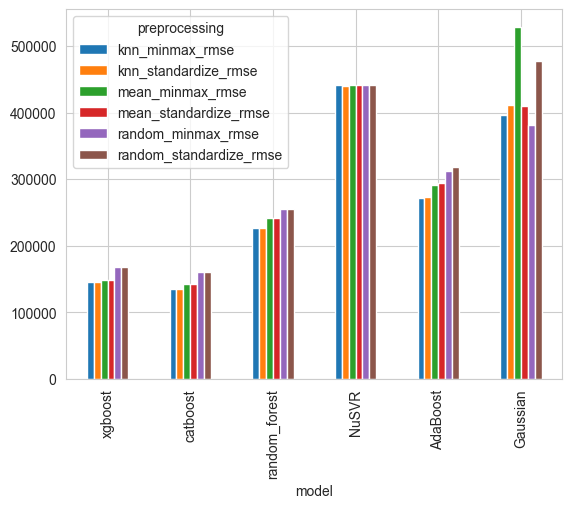

In [29]:
df_wide = pd.DataFrame({
    'xgboost': xgb_scores,
    'catboost': catboost_scores,
    'random_forest': random_forest_scores,
    'NuSVR': nusvr_scores,
    'AdaBoost': ada_boost_scores,
    'Gaussian': gussian_scores,
}).T
df_wide.index.name = 'model'
df_wide.columns.name = 'preprocessing'

df_wide.plot.bar()
df_wide


Learning rate set to 0.079593
0:	learn: 408711.3998385	test: 406258.6988602	best: 406258.6988602 (0)	total: 17ms	remaining: 17s
1:	learn: 388780.3806319	test: 386596.8630748	best: 386596.8630748 (1)	total: 25.8ms	remaining: 12.9s
2:	learn: 369750.6825519	test: 368252.5064762	best: 368252.5064762 (2)	total: 33.8ms	remaining: 11.2s
3:	learn: 352348.4096139	test: 351490.8183280	best: 351490.8183280 (3)	total: 39.3ms	remaining: 9.79s
4:	learn: 337077.1000269	test: 336431.1589187	best: 336431.1589187 (4)	total: 47.2ms	remaining: 9.4s
5:	learn: 322898.1483343	test: 322625.1129803	best: 322625.1129803 (5)	total: 51.6ms	remaining: 8.55s
6:	learn: 309462.7478748	test: 309544.7834394	best: 309544.7834394 (6)	total: 58.2ms	remaining: 8.26s
7:	learn: 297580.5418547	test: 297844.7531570	best: 297844.7531570 (7)	total: 63.2ms	remaining: 7.84s
8:	learn: 284764.2050231	test: 285454.0239272	best: 285454.0239272 (8)	total: 68.3ms	remaining: 7.52s
9:	learn: 272833.5302641	test: 274075.4036045	best: 27407

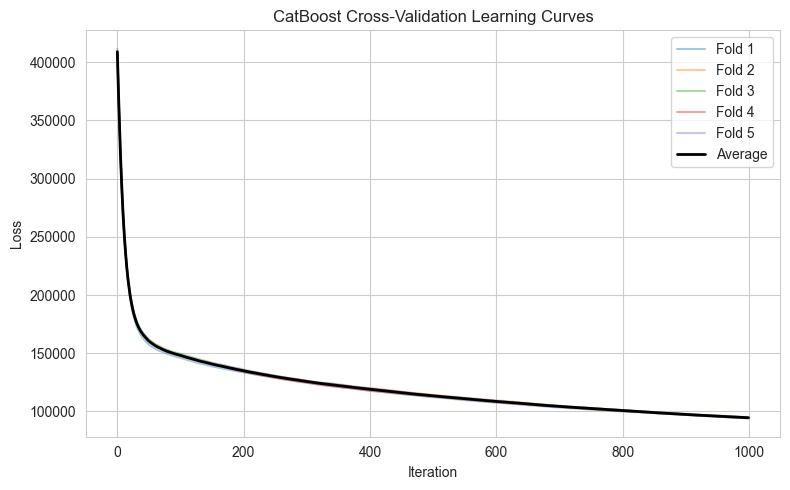

In [30]:
### Catboost 
all_curves = []
folds = split_set_into_cross_validation(knn_standardize_features, knn_target)

for i, (X_train, Y_train, X_eval, Y_eval) in enumerate(folds):
    model = CatBoostRegressor(eval_metric='RMSE', random_seed=2137)
    cat_features = X_train.select_dtypes(include=['category']).columns.tolist()

    model.fit(
        X_train,
        Y_train,
        eval_set=(X_eval, Y_eval),
        cat_features=cat_features,
    )

    evals = model.get_evals_result()
    curve = evals['learn'][model.get_param('loss_function')]
    all_curves.append(curve)

min_len = min(len(c) for c in all_curves)
trimmed = [c[:min_len] for c in all_curves]
avg_curve = np.mean(np.vstack(trimmed), axis=0).tolist()

plt.figure(figsize=(8, 5))
for idx, curve in enumerate(trimmed, 1):
    plt.plot(curve, alpha=0.4, label=f'Fold {idx}')
plt.plot(avg_curve, color='black', linewidth=2, label='Average')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('CatBoost Cross-Validation Learning Curves')
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot


def evaluate_ensemble_models(folds, base_models, meta_model):
    voting_scores = []
    stacking_scores = []

    for fold_idx, (X_train, y_train, X_test, y_test) in enumerate(folds):
        print(f"\n--- Fold {fold_idx + 1} ---")

        voting = VotingRegressor(estimators=base_models)
        voting.fit(X_train, y_train)
        y_pred_voting = voting.predict(X_test)

        stacking = StackingRegressor(estimators=base_models, final_estimator=meta_model, passthrough=False)
        stacking.fit(X_train, y_train)
        y_pred_stacking = stacking.predict(X_test)

        voting_metrics = {
            'RMSE': rmse(y_test, y_pred_voting),
            'MAE': mae(y_test, y_pred_voting),
            'R2': r2(y_test, y_pred_voting)
        }

        stacking_metrics = {
            'RMSE': rmse(y_test, y_pred_stacking),
            'MAE': mae(y_test, y_pred_stacking),
            'R2': r2(y_test, y_pred_stacking)
        }

        print("Voting:", voting_metrics)
        print("Stacking:", stacking_metrics)

        voting_scores.append(voting_metrics)
        stacking_scores.append(stacking_metrics)

    def average_metrics(scores):
        return {
            'RMSE': np.mean([s['RMSE'] for s in scores]),
            'MAE': np.mean([s['MAE'] for s in scores]),
            'R2': np.mean([s['R2'] for s in scores]),
        }

    results = {
        'Voting (avg)': average_metrics(voting_scores),
        'Stacking (avg)': average_metrics(stacking_scores),
        'Voting (folds)': voting_scores,
        'Stacking (folds)': stacking_scores
    }

    return results

In [32]:
from sklearn.linear_model import LinearRegression

X_data = apartments_data.copy()
X_data = X_data.replace({None: np.nan, 'None': np.nan})

Y = X_data["price"]
X_data = X_data.drop(columns=["price"])

category_cols = X_data.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_data.select_dtypes(include=['number']).columns.tolist()

for col in numeric_cols:
    X_data[col] = X_data[col].fillna(X_data[col].mean())

for col in category_cols:
    X_data[col] = X_data[col].fillna(X_data[col].mode()[0])
    X_data[col] = X_data[col].astype("category")

folds = split_set_into_cross_validation(X_data, Y, n_splits=5, random_state=42)

base_models = {
    "XGBoost": XGBRegressor(
        enable_categorical=True,
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=2137
    )
}

base_model_list = [
    ('xgb', base_models['XGBoost'])
]

meta_model = LinearRegression()

results = evaluate_ensemble_models(folds, base_model_list, meta_model)

print("\nŚrednie wyniki:")
print(results['Voting (avg)'])
print(results['Stacking (avg)'])


--- Fold 1 ---
Voting: {'RMSE': np.float64(145240.7423412991), 'MAE': np.float64(96886.36743271914), 'R2': np.float64(0.885358211629703)}
Stacking: {'RMSE': np.float64(145215.75078820935), 'MAE': np.float64(96757.22897291328), 'R2': np.float64(0.8853976610265808)}

--- Fold 2 ---
Voting: {'RMSE': np.float64(147690.4694674844), 'MAE': np.float64(95346.26081758722), 'R2': np.float64(0.8819141083326921)}
Stacking: {'RMSE': np.float64(147660.53310643486), 'MAE': np.float64(95138.5277107558), 'R2': np.float64(0.881961974706575)}

--- Fold 3 ---
Voting: {'RMSE': np.float64(145046.39703360433), 'MAE': np.float64(94646.4964752907), 'R2': np.float64(0.8877849279917784)}
Stacking: {'RMSE': np.float64(145113.35032540176), 'MAE': np.float64(94592.86838299419), 'R2': np.float64(0.8876813073207385)}

--- Fold 4 ---
Voting: {'RMSE': np.float64(153190.85404984056), 'MAE': np.float64(99307.61269622092), 'R2': np.float64(0.8715095581394492)}
Stacking: {'RMSE': np.float64(153111.55587772594), 'MAE': np.

### Optymalizacja cech

#### Optuna

In [45]:
import optuna

X_train, y_train, X_test, y_test = split_set_into_training(knn_minmax_features, knn_target, 0.8)
cat_features = X_data.select_dtypes(include=['object', 'category']).columns.tolist()
feature_names = X_train.columns.tolist()


def objective(trial):
    selected_features = [f for f in feature_names if trial.suggest_categorical(f"use_{f}", [True, False])]

    if not selected_features:
        return float("inf")

    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]

    selected_categoricals = [f for f in selected_features if f in cat_features]

    model = CatBoostRegressor(
        eval_metric='RMSE',
        random_seed=2137,
        verbose=100
    )
    model.fit(X_train_sel, y_train, eval_set=(X_test_sel, y_test), early_stopping_rounds=20, verbose=0,
              cat_features=selected_categoricals)

    preds = model.predict(X_test_sel)
    return rmse(y_test, preds)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

best_trial = study.best_trial
selected_features = [f for f in feature_names if best_trial.params.get(f"use_{f}", False)]

print("Selected features:", selected_features)
print("Best RMSE:", best_trial.value)

[I 2025-05-24 21:08:17,931] A new study created in memory with name: no-name-bb343750-c2da-44df-9362-d9bf045febd2
[I 2025-05-24 21:08:20,019] Trial 0 finished with value: 218453.71968258364 and parameters: {'use_city': True, 'use_type': False, 'use_squareMeters': False, 'use_rooms': True, 'use_floor': False, 'use_floorCount': False, 'use_buildYear': False, 'use_latitude': True, 'use_longitude': False, 'use_centreDistance': False, 'use_poiCount': True, 'use_schoolDistance': True, 'use_clinicDistance': False, 'use_postOfficeDistance': False, 'use_kindergartenDistance': False, 'use_restaurantDistance': True, 'use_collegeDistance': True, 'use_pharmacyDistance': True, 'use_ownership': False, 'use_buildingMaterial': True, 'use_condition': True, 'use_hasParkingSpace': True, 'use_hasBalcony': False, 'use_hasElevator': True, 'use_hasSecurity': False, 'use_hasStorageRoom': True}. Best is trial 0 with value: 218453.71968258364.
[I 2025-05-24 21:08:21,533] Trial 1 finished with value: 277133.54236

Selected features: ['city', 'type', 'squareMeters', 'rooms', 'floorCount', 'buildYear', 'latitude', 'longitude', 'clinicDistance', 'buildingMaterial', 'condition', 'hasElevator']
Best RMSE: 135887.49115019396


Optuna wykazała, że najmniejszy błąd jest uzyskiwany dla następujących cech:
- city,
- type
- squareMeters,
- rooms,
- floorCount,
- buildYear,
- latitude,
- longitude,
- clinicDistance,
- buildingMaterial,
- condition,
- hasElavator

#### Macierz koleracji

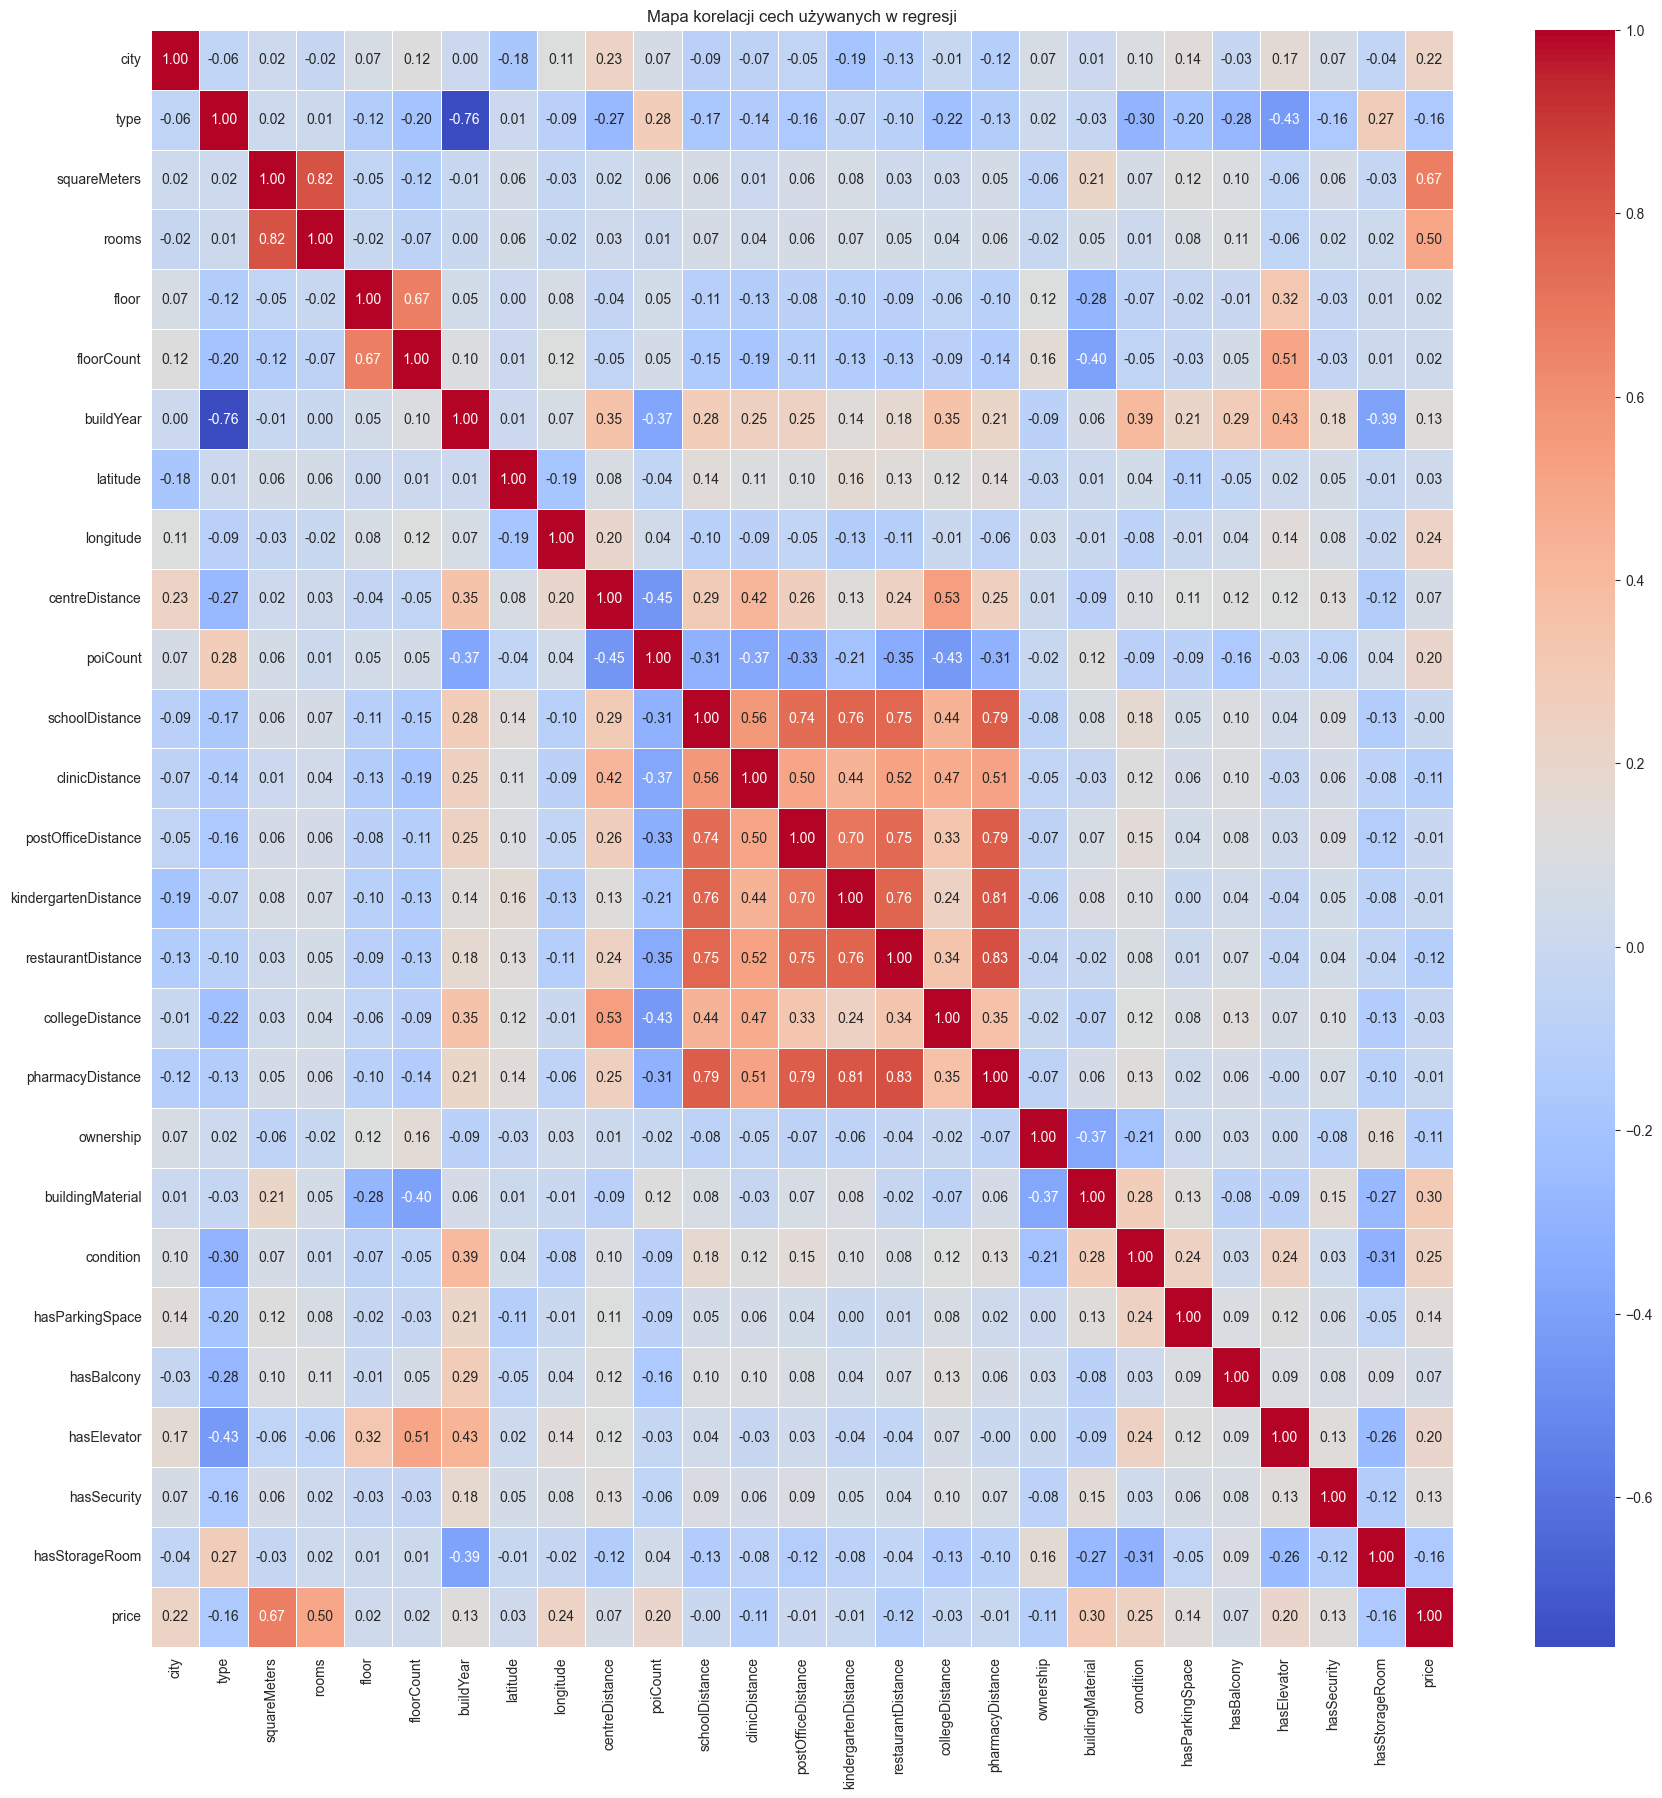

In [39]:
filtered_data = apartments_data[selected_columns].copy()

filtered_data["hasElevator"] = filtered_data["hasElevator"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["hasParkingSpace"] = filtered_data["hasParkingSpace"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["type"] = filtered_data["type"].map({"blockOfFlats": 1, "apartmentBuilding": 0, "tenement": 2}).astype(
    "Int64")
filtered_data["hasStorageRoom"] = filtered_data["hasStorageRoom"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["buildingMaterial"] = filtered_data["buildingMaterial"].map({"brick": 1, "concreteSlab": 0}).astype(
    "Int64")
filtered_data["hasBalcony"] = filtered_data["hasBalcony"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["hasSecurity"] = filtered_data["hasSecurity"].map({"yes": 1, "no": 0}).astype("Int64")

filtered_data["ownership"] = filtered_data["ownership"].map({
    "condominium": 0,
    "cooperative": 1,
    "udział": 2
}).astype("Int64")

filtered_data["condition"] = filtered_data["condition"].map({
    "low": 0,
    "premium": 1
}).astype("Int64")

filtered_data["city"] = filtered_data["city"].astype("category").cat.codes

corr_matrix = filtered_data.corr(method='pearson')

plt.figure(figsize=(21, 21))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa korelacji cech używanych w regresji")
plt.show()



Największe relacje występują pomiędzy następującymi cechami:
- pharmacyDistance & restaurantDistance: 0.83
- rooms & squareMeters: 0.82
- kindergardenDistance & pharmacyDistnace: 0.81
- postofficeDistance & pharmacyDistance: 0.79
- schoolDistance & pharmacyDistance: 0.79
- kindergardenDistance & restaurantDistance: 0.76

A najmniejsze:
- buildYear & type: -0.76
- centerDistance & poiCount: -0.45
- hasElevator & type: -0.43
- collageDistance & poiCount: -0.43
- buildingMaterial & floorCount: -0.40

### Optymalizacja parametrów

#### Grid search

In [53]:
from sklearn.model_selection import GridSearchCV

X_train, y_train, X_test, y_test = split_set_into_training(knn_minmax_features, knn_target, 0.8)

cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

model = CatBoostRegressor(
    cat_features=cat_features,
    verbose=0,
    random_seed=2137
)

param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'l2_leaf_reg': [1, 2, 3, 5],
    'iterations': [100, 200, 300, 400],
    'border_count': [20, 40, 50, 100],
    'random_strength': [1e-3, 1e-2, 0.4, 3.0],
    'bagging_temperature': [0.0, 0.2, 0.5, 1.0],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best RMSE:", -grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set RMSE:", rmse(y_test, y_pred))

Best RMSE: 138991.67409100255
Best Parameters: {'depth': 8, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Test set RMSE: 136726.87330758432


#### Optuna

In [54]:
import optuna

X_train, y_train, X_test, y_test = split_set_into_training(knn_minmax_features, knn_target, 0.8)
cat_features = X_data.select_dtypes(include=['object', 'category']).columns.tolist()
feature_names = X_data.columns.tolist()


def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "verbose": 0,
        "task_type": "CPU",
        "random_seed": 2137,
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), early_stopping_rounds=20,
              verbose=0)

    preds = model.predict(X_test)
    return rmse(y_test, preds)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

best_model = CatBoostRegressor(**study.best_params, verbose=0)
best_model.fit(X_train, y_train, cat_features=cat_features)

y_pred = best_model.predict(X_test)
print("Final test RMSE:", rmse(y_test, y_pred))

[I 2025-05-24 21:42:56,632] A new study created in memory with name: no-name-33fefafe-9f9d-4d1a-a893-acd263637613
[I 2025-05-24 21:43:00,793] Trial 0 finished with value: 247088.2482627797 and parameters: {'iterations': 452, 'depth': 9, 'learning_rate': 0.002151230101939454, 'l2_leaf_reg': 9.141332370791929, 'random_strength': 0.025962907540424525, 'bagging_temperature': 0.1699726874787374, 'border_count': 176}. Best is trial 0 with value: 247088.2482627797.
[I 2025-05-24 21:43:01,608] Trial 1 finished with value: 171570.13756580418 and parameters: {'iterations': 366, 'depth': 4, 'learning_rate': 0.011344730930638617, 'l2_leaf_reg': 7.622270364730255, 'random_strength': 0.0014924337951244759, 'bagging_temperature': 0.6213868304078456, 'border_count': 243}. Best is trial 1 with value: 171570.13756580418.
[I 2025-05-24 21:43:01,880] Trial 2 finished with value: 151867.84055151584 and parameters: {'iterations': 169, 'depth': 4, 'learning_rate': 0.11525293348427242, 'l2_leaf_reg': 8.616147

Best parameters: {'iterations': 983, 'depth': 8, 'learning_rate': 0.07461424276941765, 'l2_leaf_reg': 2.4433557000283392, 'random_strength': 0.865260393364813, 'bagging_temperature': 0.43907376824704475, 'border_count': 212}
Best RMSE: 132646.42792908355
Final test RMSE: 133310.0383197116


#### Genetics

In [57]:
import pygad
import numpy as np
from catboost import CatBoostRegressor

X_train, y_train, X_test, y_test = split_set_into_training(knn_minmax_features, knn_target, 0.8)

cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

param_bounds = {
    "depth": (4, 10),
    "learning_rate": (0.01, 0.3),
    "l2_leaf_reg": (1.0, 10.0),
    "iterations": (100, 1000),
    "border_count": (32, 255),
    "random_strength": (1e-3, 10),
    "bagging_temperature": (0.0, 1.0)
}

param_names = list(param_bounds.keys())


def decode_chromosome(solution):
    params = {}
    for i, key in enumerate(param_names):
        low, high = param_bounds[key]
        val = solution[i]
        val = max(min(val, high), low)

        if key in ["depth", "iterations", "border_count"]:
            params[key] = int(round(val))
        else:
            params[key] = float(val)

    params["verbose"] = 0
    params["random_seed"] = 2137
    params["task_type"] = "CPU"
    return params


def fitness_func(ga_instance, solution, solution_idx):
    params = decode_chromosome(solution)
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_test, y_test),
        early_stopping_rounds=20,
        verbose=0
    )
    preds = model.predict(X_test)
    return -rmse(y_test, preds)


def on_generation(ga_instance):
    best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
    print(f"Generation {ga_instance.generations_completed}: Best Fitness = {best_solution_fitness}")
    print("Best solution parameters:")
    decoded_params = decode_chromosome(best_solution)
    for k, v in decoded_params.items():
        print(f"  {k}: {v}")
    print("-" * 30)


num_generations = 20
num_parents_mating = 5
sol_per_pop = 10
num_genes = len(param_names)

gene_space = [
    {"low": param_bounds[name][0], "high": param_bounds[name][1]}
    for name in param_names
]

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    gene_space=gene_space,
    keep_elitism=2,
    parent_selection_type="sss",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=20,
    random_seed=2137,
    parallel_processing=["thread", 5],
    on_generation=on_generation,
)

ga_instance.run()

best_solution, best_solution_fitness, _ = ga_instance.best_solution()
best_params = decode_chromosome(best_solution)
print("Best Parameters found by PyGAD:")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print(f"Best RMSE: {-best_solution_fitness}")


Generation 1: Best Fitness = -135649.68268853216
Best solution parameters:
  depth: 8
  learning_rate: 0.1935898946779819
  l2_leaf_reg: 8.041951018017441
  iterations: 898
  border_count: 228
  random_strength: 8.643968550881644
  bagging_temperature: 0.16206717432441498
  verbose: 0
  random_seed: 2137
  task_type: CPU
------------------------------
Generation 2: Best Fitness = -133506.7331240119
Best solution parameters:
  depth: 8
  learning_rate: 0.1935898946779819
  l2_leaf_reg: 8.041951018017441
  iterations: 898
  border_count: 203
  random_strength: 6.89393136615498
  bagging_temperature: 0.21047289610927422
  verbose: 0
  random_seed: 2137
  task_type: CPU
------------------------------
Generation 3: Best Fitness = -133506.7331240119
Best solution parameters:
  depth: 8
  learning_rate: 0.1935898946779819
  l2_leaf_reg: 8.041951018017441
  iterations: 898
  border_count: 203
  random_strength: 6.89393136615498
  bagging_temperature: 0.21047289610927422
  verbose: 0
  random_s

### Porównanie wyników:
Grid search: 
- 'iterations': 400,
- 'depth': 8, 
- 'l2_leaf_reg': 1,
- 'learning_rate': 0.1
- BEST RMSE: 138991

Optuna:
- 'iterations': 983,
- 'depth': 8,
- 'learning_rate': 0.07461424276941765,
- 'l2_leaf_reg': 2.4433557000283392,
- 'random_strength': 0.865260393364813, 
- 'bagging_temperature': 0.43907376824704475,
- 'border_count': 212
- Best RMSE: 132646.42792908355

Genetics:
- iterations: 900
- depth: 7
- learning_rate: 0.1935898946779819
- l2_leaf_reg: 8.041951018017441
- border_count: 203
- random_strength: 6.896831777941098
- bagging_temperature: 0.542035450050984
- Best RMSE: 132892.65892879094

Najlepszy wynik został uzyskane przy pomocy optuny. Jednak jest on bardzo zbliżony do wyniku uzyskanego przy pomocy algortymu genetycznego i część parametrów takich jak `depth`, `border_count`, `baggin_temperature`, `iterations` jest do siebie bardzo zbliżona. 

### Optymalizacja najlepszego modelu

In [60]:
final_features = ['city', 'type', 'squareMeters', 'rooms', 'floorCount', 'buildYear', 'latitude', 'longitude',
                  'clinicDistance', 'buildingMaterial', 'condition', 'hasElevator']

final_params = {
    'depth': 7,
    'learning_rate': 0.1935898946779819,
    'l2_leaf_reg': 8.041951018017441,
    'iterations': 900,
    'border_count': 203,
    'random_strength': 6.896831777941098,
    'bagging_temperature': 0.542035450050984,
    'verbose': 0,
    'random_seed': 2137,
    'task_type': 'CPU',
}

X_train, y_train, X_test, y_test = split_set_into_training(knn_minmax_features, knn_target, 0.8)
X_train = X_train[final_features]
X_test = X_test[final_features]

cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

model = CatBoostRegressor(**final_params)
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=0)

y_pred = model.predict(X_test)
print("Final test RMSE:", rmse(y_test, y_pred))

Final test RMSE: 136394.6542324522
